# December 2025 Status

(Most of these code chunks are me redoing some of the slides that I currently have in my slidedeck)

(see message thread with Evey on Jan 8 2026 for reference)

## Slide 3 - Time Summation

=== FILE COVERAGE (pre-run) ===
Total JSON files found: 809
Session_outcomes files excluded: 8
Candidate session files scanned: 801

=== FILE COVERAGE (post-run) ===
Skip summary: {'load_fail': 0, 'no_utterances': 636, 'too_few_timestamps': 1, 'no_rows_after_filters': 8}
Sessions contributing at least 1 coded utterance: 156
Rows in df: 44370


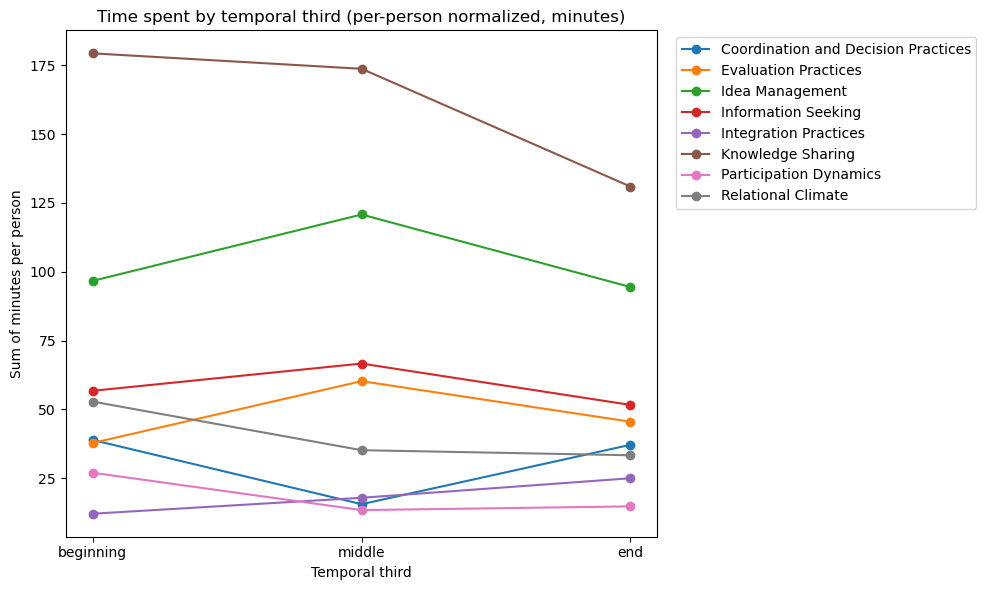

code,when,Coordination and Decision Practices,Evaluation Practices,Idea Management,Information Seeking,Integration Practices,Knowledge Sharing,Participation Dynamics,Relational Climate
0,beginning,38.892210,37.828009,96.710728,56.766349,12.109595,179.369813,26.991075,52.840434
1,middle,15.568522,60.268856,120.820733,66.658447,17.896984,173.755457,13.413868,35.182812
2,end,37.142128,45.529101,94.473047,51.638279,24.993976,130.974741,14.773891,33.347467


In [23]:
import os, json, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
BASE_DIR = '/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/gemini_data_analysis/data'  # <-- change this
# For quick testing with your uploaded sample in this environment, uncomment:
# BASE_DIR = "/mnt/data"

TEMPORAL_ORDER = ["beginning", "middle", "end"]

# Multi-label handling:
# False = full duration credited to every code present (allows overlaps)
# True  = split duration evenly across all codes in that utterance (no within-utterance double count)
SPLIT_MULTI_LABEL_TIME = False

IGNORE_CODES = {"None", "Other", ""}

# If timestamps wrap (e.g., 09:39 -> 00:29), we "unwrap" them by adding an offset.
# This threshold (seconds) decides what counts as a wrap. 30s is conservative.
WRAP_THRESHOLD_SEC = 30


# =========================
# HELPERS
# =========================
def safe_load_json(path: str):
    with open(path, "r") as f:
        return json.load(f)

def extract_utterances(obj):
    """
    Tries common structures for your utterance-level session JSONs.
    Your example uses 'all_data'.
    """
    if isinstance(obj, list):
        return obj
    if isinstance(obj, dict):
        for k in ["all_data", "utterances", "utterance_list", "data", "items"]:
            if k in obj and isinstance(obj[k], list):
                return obj[k]
    return None

def to_seconds(val):
    if val is None:
        return np.nan
    if isinstance(val, (int, float)):
        return float(val)
    try:
        return float(str(val).strip())
    except:
        return np.nan

def parse_timestamp_to_sec(ts):
    """
    Accepts:
      - "MM:SS"
      - "HH:MM:SS"
    Returns seconds or NaN.
    """
    if ts is None:
        return np.nan
    s = str(ts).strip()
    if not s:
        return np.nan
    parts = s.split(":")
    try:
        parts = [int(p) for p in parts]
    except:
        return np.nan
    if len(parts) == 2:
        mm, ss = parts
        return mm * 60 + ss
    if len(parts) == 3:
        hh, mm, ss = parts
        return hh * 3600 + mm * 60 + ss
    return np.nan

def unwrap_time(seconds_list, wrap_threshold=WRAP_THRESHOLD_SEC):
    """
    Make a sequence monotonic by adding offsets when it appears to reset.
    If time goes backwards by more than threshold, treat as wrap/reset and add 3600s
    until monotonic.
    """
    out = []
    offset = 0.0
    prev = None
    for x in seconds_list:
        if not np.isfinite(x):
            out.append(np.nan)
            continue
        if prev is not None and np.isfinite(prev):
            if x < prev - wrap_threshold:
                while x + offset < prev:
                    offset += 3600.0
        gx = x + offset
        out.append(gx)
        prev = gx
    return out

def is_session_outcomes_file(path: str):
    return os.path.basename(path).endswith("_session_outcomes.json")


# =========================
# SCAN FILES + COVERAGE REPORTING
# =========================
json_paths = glob.glob(os.path.join(BASE_DIR, "**", "*.json"), recursive=True)
outcomes_paths = [p for p in json_paths if is_session_outcomes_file(p)]
session_paths = [p for p in json_paths if not is_session_outcomes_file(p)]

print("=== FILE COVERAGE (pre-run) ===")
print("Total JSON files found:", len(json_paths))
print("Session_outcomes files excluded:", len(outcomes_paths))
print("Candidate session files scanned:", len(session_paths))

skip = {
    "load_fail": 0,
    "no_utterances": 0,
    "too_few_timestamps": 0,
    "no_rows_after_filters": 0,
}

rows = []
processed_sessions = set()


for path in session_paths:
    try:
        obj = safe_load_json(path)
    except Exception:
        skip["load_fail"] += 1
        continue

    utterances = extract_utterances(obj)
    if not utterances:
        skip["no_utterances"] += 1
        continue

    # Use a unique-ish session id (path-relative) to avoid filename collisions across conferences
    session_id = os.path.relpath(path, BASE_DIR).replace(os.sep, "__").replace(".json", "")

    rows_before = len(rows)

    # Speakers for per-person normalization
    speakers = {(u.get("speaker") or "").strip() for u in utterances}
    speakers = {s for s in speakers if s}
    n_speakers = max(len(speakers), 1)

    # Build a per-utterance time axis (prefer start_time; else timestamp)
    t_raw = []
    for u in utterances:
        st = u.get("start_time", None)
        ts = u.get("timestamp", None)
        sec = parse_timestamp_to_sec(st) if st is not None else parse_timestamp_to_sec(ts)
        t_raw.append(sec)

    # Unwrap to global monotonic time within the session
    global_sec = unwrap_time(t_raw)

    # If all NaN, fall back to utterance index
    if np.all(~np.isfinite(global_sec)):
        global_sec = list(range(len(utterances)))

    # Assign temporal thirds from global_sec percentiles
    g = np.array(global_sec, dtype=float)
    if np.isfinite(g).sum() < 3:
        skip["too_few_timestamps"] += 1
        continue

    g_min, g_max = np.nanmin(g), np.nanmax(g)
    if g_max == g_min:
        g_norm = np.zeros_like(g)
    else:
        g_norm = (g - g_min) / (g_max - g_min)

    third_label = np.full(len(g_norm), None, dtype=object)
    third_label[(g_norm >= 0.0) & (g_norm < 1/3)] = "beginning"
    third_label[(g_norm >= 1/3) & (g_norm < 2/3)] = "middle"
    third_label[(g_norm >= 2/3) & (g_norm <= 1.0)] = "end"

    for u, when in zip(utterances, third_label):
        if when not in TEMPORAL_ORDER:
            continue

        dur_sec = to_seconds(u.get("speaking_duration"))
        if not np.isfinite(dur_sec) or dur_sec <= 0:
            continue

        ann = u.get("annotations", {})
        if not isinstance(ann, dict) or len(ann) == 0:
            continue

        codes = [c.strip() for c in ann.keys() if isinstance(c, str)]
        codes = [c for c in codes if c not in IGNORE_CODES]
        if not codes:
            continue

        if SPLIT_MULTI_LABEL_TIME:
            per_code_sec = dur_sec / len(codes)
        else:
            per_code_sec = dur_sec

        # Convert to minutes *after* multi-label logic
        per_code_min = per_code_sec / 60.0
        per_code_min_per_person = per_code_min / n_speakers

        for code in codes:
            rows.append({
                "session_id": session_id,
                "when": when,
                "code": code,
                "time_min_per_person": per_code_min_per_person,
            })

    if len(rows) == rows_before:
        skip["no_rows_after_filters"] += 1
    else:
        processed_sessions.add(session_id)


df = pd.DataFrame(rows)

print("\n=== FILE COVERAGE (post-run) ===")
print("Skip summary:", skip)
print("Sessions contributing at least 1 coded utterance:", len(processed_sessions))
print("Rows in df:", len(df))

if df.empty:
    raise ValueError(
        "No utterance annotations found. Likely BASE_DIR is pointing at the wrong folder, "
        "or your individual session files store utterances under a different key than expected."
    )

# =========================
# AGGREGATE + PLOT (MINUTES)
# =========================
agg = df.groupby(["code", "when"], as_index=False)["time_min_per_person"].sum()
agg["when"] = pd.Categorical(agg["when"], categories=TEMPORAL_ORDER, ordered=True)
agg = agg.sort_values(["code", "when"])

wide = agg.pivot(index="when", columns="code", values="time_min_per_person").fillna(0.0)
wide = wide.loc[TEMPORAL_ORDER]

plt.figure(figsize=(10, 6))
for code in wide.columns:
    plt.plot(wide.index.astype(str), wide[code].values, marker="o", label=code)

plt.title("Time spent by temporal third (per-person normalized, minutes)")
plt.xlabel("Temporal third")
plt.ylabel("Sum of minutes per person")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

display(wide.reset_index())

## Slide 3 - Code Annotation Summation

=== FILE COVERAGE (pre-run) ===
Total JSON files found: 809
Session_outcomes files excluded: 8
Candidate session files scanned: 801

=== FILE COVERAGE (post-run) ===
Skip summary: {'load_fail': 0, 'no_utterances': 636, 'too_few_timestamps': 1, 'no_rows_after_filters': 8}
Sessions contributing at least 1 coded utterance: 156
Rows in df: 46910


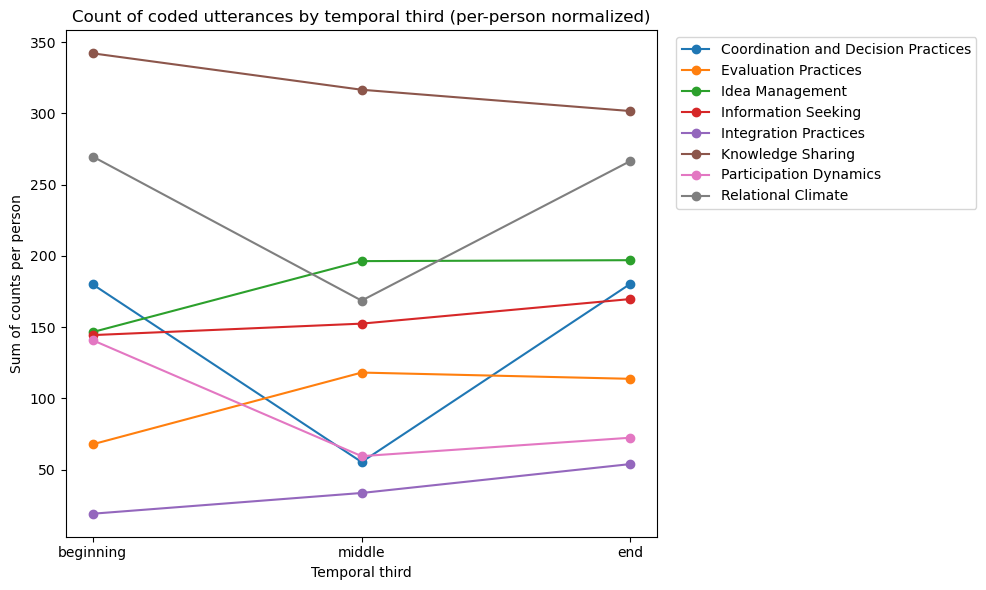

code,when,Coordination and Decision Practices,Evaluation Practices,Idea Management,Information Seeking,Integration Practices,Knowledge Sharing,Participation Dynamics,Relational Climate
0,beginning,179.954750,67.778589,146.544388,144.395960,19.038241,342.143563,140.778523,269.675466
1,middle,55.297938,118.097746,196.314909,152.440817,33.583884,316.602484,59.437393,168.600632
2,end,180.409728,113.713725,196.970621,169.698563,53.876424,301.645214,72.368582,266.586175


In [24]:
import os, json, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
BASE_DIR = '/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/gemini_data_analysis/data'
# BASE_DIR = "/mnt/data"  # quick test in this environment

TEMPORAL_ORDER = ["beginning", "middle", "end"]

# Multi-label handling for COUNT:
# False = each utterance contributes +1 to every code present (allows overlaps)
# True  = split 1.0 evenly across all codes in that utterance (no within-utterance double count)
SPLIT_MULTI_LABEL_COUNTS = False

IGNORE_CODES = {"None", "Other", ""}

WRAP_THRESHOLD_SEC = 30


# =========================
# HELPERS
# =========================
def safe_load_json(path: str):
    with open(path, "r") as f:
        return json.load(f)

def extract_utterances(obj):
    """
    Tries common structures for your utterance-level session JSONs.
    Your example uses 'all_data'.
    """
    if isinstance(obj, list):
        return obj
    if isinstance(obj, dict):
        for k in ["all_data", "utterances", "utterance_list", "data", "items"]:
            if k in obj and isinstance(obj[k], list):
                return obj[k]
    return None

def parse_timestamp_to_sec(ts):
    """
    Accepts:
      - "MM:SS"
      - "HH:MM:SS"
    Returns seconds or NaN.
    """
    if ts is None:
        return np.nan
    s = str(ts).strip()
    if not s:
        return np.nan
    parts = s.split(":")
    try:
        parts = [int(p) for p in parts]
    except:
        return np.nan
    if len(parts) == 2:
        mm, ss = parts
        return mm * 60 + ss
    if len(parts) == 3:
        hh, mm, ss = parts
        return hh * 3600 + mm * 60 + ss
    return np.nan

def unwrap_time(seconds_list, wrap_threshold=WRAP_THRESHOLD_SEC):
    """
    Make a sequence monotonic by adding offsets when it appears to reset.
    If time goes backwards by more than threshold, treat as wrap/reset and add 3600s
    until monotonic.
    """
    out = []
    offset = 0.0
    prev = None
    for x in seconds_list:
        if not np.isfinite(x):
            out.append(np.nan)
            continue
        if prev is not None and np.isfinite(prev):
            if x < prev - wrap_threshold:
                while x + offset < prev:
                    offset += 3600.0
        gx = x + offset
        out.append(gx)
        prev = gx
    return out

def is_session_outcomes_file(path: str):
    return os.path.basename(path).endswith("_session_outcomes.json")


# =========================
# SCAN FILES + COVERAGE REPORTING
# =========================
json_paths = glob.glob(os.path.join(BASE_DIR, "**", "*.json"), recursive=True)
outcomes_paths = [p for p in json_paths if is_session_outcomes_file(p)]
session_paths = [p for p in json_paths if not is_session_outcomes_file(p)]

print("=== FILE COVERAGE (pre-run) ===")
print("Total JSON files found:", len(json_paths))
print("Session_outcomes files excluded:", len(outcomes_paths))
print("Candidate session files scanned:", len(session_paths))

skip = {
    "load_fail": 0,
    "no_utterances": 0,
    "too_few_timestamps": 0,
    "no_rows_after_filters": 0,
}

rows = []
processed_sessions = set()

for path in session_paths:
    try:
        obj = safe_load_json(path)
    except Exception:
        skip["load_fail"] += 1
        continue

    utterances = extract_utterances(obj)
    if not utterances:
        skip["no_utterances"] += 1
        continue

    # Use a unique-ish session id (path-relative) to avoid filename collisions across conferences
    session_id = os.path.relpath(path, BASE_DIR).replace(os.sep, "__").replace(".json", "")

    rows_before = len(rows)

    # Speakers for per-person normalization
    speakers = {(u.get("speaker") or "").strip() for u in utterances}
    speakers = {s for s in speakers if s}
    n_speakers = max(len(speakers), 1)

    # Build a per-utterance time axis (prefer start_time; else timestamp)
    t_raw = []
    for u in utterances:
        st = u.get("start_time", None)
        ts = u.get("timestamp", None)
        sec = parse_timestamp_to_sec(st) if st is not None else parse_timestamp_to_sec(ts)
        t_raw.append(sec)

    # Unwrap to global monotonic time within the session
    global_sec = unwrap_time(t_raw)

    # If all NaN, fall back to utterance index
    if np.all(~np.isfinite(global_sec)):
        global_sec = list(range(len(utterances)))

    # Assign temporal thirds from global_sec percentiles
    g = np.array(global_sec, dtype=float)
    if np.isfinite(g).sum() < 3:
        skip["too_few_timestamps"] += 1
        continue

    g_min, g_max = np.nanmin(g), np.nanmax(g)
    if g_max == g_min:
        g_norm = np.zeros_like(g)
    else:
        g_norm = (g - g_min) / (g_max - g_min)

    third_label = np.full(len(g_norm), None, dtype=object)
    third_label[(g_norm >= 0.0) & (g_norm < 1/3)] = "beginning"
    third_label[(g_norm >= 1/3) & (g_norm < 2/3)] = "middle"
    third_label[(g_norm >= 2/3) & (g_norm <= 1.0)] = "end"

    for u, when in zip(utterances, third_label):
        if when not in TEMPORAL_ORDER:
            continue

        ann = u.get("annotations", {})
        if not isinstance(ann, dict) or len(ann) == 0:
            continue

        codes = [c.strip() for c in ann.keys() if isinstance(c, str)]
        codes = [c for c in codes if c not in IGNORE_CODES]
        if not codes:
            continue

        # COUNT contribution per utterance
        if SPLIT_MULTI_LABEL_COUNTS:
            per_code_count = 1.0 / len(codes)
        else:
            per_code_count = 1.0

        per_code_count_per_person = per_code_count / n_speakers

        for code in codes:
            rows.append({
                "session_id": session_id,
                "when": when,
                "code": code,
                "count_per_person": per_code_count_per_person,
            })

    if len(rows) == rows_before:
        skip["no_rows_after_filters"] += 1
    else:
        processed_sessions.add(session_id)


df = pd.DataFrame(rows)

print("\n=== FILE COVERAGE (post-run) ===")
print("Skip summary:", skip)
print("Sessions contributing at least 1 coded utterance:", len(processed_sessions))
print("Rows in df:", len(df))

if df.empty:
    raise ValueError(
        "No utterance annotations found. Likely BASE_DIR is pointing at the wrong folder, "
        "or your individual session files store utterances under a different key than expected."
    )

# =========================
# AGGREGATE + PLOT (COUNTS)
# =========================
agg = df.groupby(["code", "when"], as_index=False)["count_per_person"].sum()
agg["when"] = pd.Categorical(agg["when"], categories=TEMPORAL_ORDER, ordered=True)
agg = agg.sort_values(["code", "when"])

wide = agg.pivot(index="when", columns="code", values="count_per_person").fillna(0.0)
wide = wide.loc[TEMPORAL_ORDER]

plt.figure(figsize=(10, 6))
for code in wide.columns:
    plt.plot(wide.index.astype(str), wide[code].values, marker="o", label=code)

plt.title("Count of coded utterances by temporal third (per-person normalized)")
plt.xlabel("Temporal third")
plt.ylabel("Sum of counts per person")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

display(wide.reset_index())

## Slide 4

In [25]:
import os, json, glob
import numpy as np
import pandas as pd

BASE_DIR = '/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/gemini_data_analysis/data'

USE_TIME = True          # True -> time (minutes), False -> counts
USE_FIRST_THIRD_ONLY = True

SPLIT_MULTI_LABEL = False  # same meaning as before
IGNORE_CODES = {"None", "Other", ""}

WRAP_THRESHOLD_SEC = 30
TEMPORAL_ORDER = ["beginning", "middle", "end"]

def safe_load_json(path: str):
    with open(path, "r") as f:
        return json.load(f)

def extract_utterances(obj):
    if isinstance(obj, list):
        return obj
    if isinstance(obj, dict):
        for k in ["all_data", "utterances", "utterance_list", "data", "items"]:
            if k in obj and isinstance(obj[k], list):
                return obj[k]
    return None

def to_seconds(val):
    if val is None:
        return np.nan
    if isinstance(val, (int, float)):
        return float(val)
    try:
        return float(str(val).strip())
    except:
        return np.nan

def parse_timestamp_to_sec(ts):
    if ts is None:
        return np.nan
    s = str(ts).strip()
    if not s:
        return np.nan
    parts = s.split(":")
    try:
        parts = [int(p) for p in parts]
    except:
        return np.nan
    if len(parts) == 2:
        mm, ss = parts
        return mm * 60 + ss
    if len(parts) == 3:
        hh, mm, ss = parts
        return hh * 3600 + mm * 60 + ss
    return np.nan

def unwrap_time(seconds_list, wrap_threshold=WRAP_THRESHOLD_SEC):
    out, offset, prev = [], 0.0, None
    for x in seconds_list:
        if not np.isfinite(x):
            out.append(np.nan); continue
        if prev is not None and np.isfinite(prev) and x < prev - wrap_threshold:
            while x + offset < prev:
                offset += 3600.0
        gx = x + offset
        out.append(gx)
        prev = gx
    return out

def is_session_outcomes_file(path: str):
    return os.path.basename(path).endswith("_session_outcomes.json")

# -------------------------
# Scan session files
# -------------------------
json_paths = glob.glob(os.path.join(BASE_DIR, "**", "*.json"), recursive=True)
session_paths = [p for p in json_paths if not is_session_outcomes_file(p)]

rows = []

for path in session_paths:
    try:
        obj = safe_load_json(path)
    except Exception:
        continue

    utterances = extract_utterances(obj)
    if not utterances:
        continue

    session_id = os.path.relpath(path, BASE_DIR).replace(os.sep, "__").replace(".json", "")

    # build global monotonic time to assign thirds
    t_raw = []
    for u in utterances:
        st = u.get("start_time", None)
        ts = u.get("timestamp", None)
        sec = parse_timestamp_to_sec(st) if st is not None else parse_timestamp_to_sec(ts)
        t_raw.append(sec)

    global_sec = unwrap_time(t_raw)
    if np.all(~np.isfinite(global_sec)):
        global_sec = list(range(len(utterances)))

    g = np.array(global_sec, dtype=float)
    if np.isfinite(g).sum() < 3:
        continue

    g_min, g_max = np.nanmin(g), np.nanmax(g)
    g_norm = np.zeros_like(g) if g_max == g_min else (g - g_min) / (g_max - g_min)

    third_label = np.full(len(g_norm), None, dtype=object)
    third_label[(g_norm >= 0.0) & (g_norm < 1/3)] = "beginning"
    third_label[(g_norm >= 1/3) & (g_norm < 2/3)] = "middle"
    third_label[(g_norm >= 2/3) & (g_norm <= 1.0)] = "end"

    for u, when in zip(utterances, third_label):
        if when not in TEMPORAL_ORDER:
            continue
        if USE_FIRST_THIRD_ONLY and when != "beginning":
            continue

        speaker = (u.get("speaker") or "").strip()
        if not speaker:
            continue

        ann = u.get("annotations", {})
        if not isinstance(ann, dict) or len(ann) == 0:
            continue

        codes = [c.strip() for c in ann.keys() if isinstance(c, str)]
        codes = [c for c in codes if c not in IGNORE_CODES]
        if not codes:
            continue

        # contribution
        if USE_TIME:
            dur_sec = to_seconds(u.get("speaking_duration"))
            if not np.isfinite(dur_sec) or dur_sec <= 0:
                continue
            base_val = (dur_sec / 60.0)  # minutes
        else:
            base_val = 1.0  # one utterance

        if SPLIT_MULTI_LABEL:
            per_code_val = base_val / len(codes)
        else:
            per_code_val = base_val

        for code in codes:
            rows.append({
                "session_id": session_id,
                "speaker": speaker,
                "code": code,
                "value": per_code_val
            })

df_long = pd.DataFrame(rows)
if df_long.empty:
    raise ValueError("No rows produced. Check BASE_DIR and annotation keys.")

# pivot to person-level wide features
df_indiv = (
    df_long
    .groupby(["session_id", "speaker", "code"], as_index=False)["value"].sum()
    .pivot_table(index=["session_id", "speaker"], columns="code", values="value", fill_value=0.0)
    .reset_index()
)

print("df_indiv shape:", df_indiv.shape)
display(df_indiv.head())

df_indiv shape: (1576, 10)


code,session_id,speaker,Coordination and Decision Practices,Evaluation Practices,Idea Management,Information Seeking,Integration Practices,Knowledge Sharing,Participation Dynamics,Relational Climate
0,2020NES__session_data__2020_11_05_NES_S1,Alissa Park,6.183333,1.083333,3.883333,2.533333,0.0,9.333333,0.000000,0.883333
1,2020NES__session_data__2020_11_05_NES_S1,Chris Gorski,0.000000,0.000000,0.000000,0.000000,0.0,0.116667,0.000000,0.000000
2,2020NES__session_data__2020_11_05_NES_S1,Emily Ryan,0.000000,0.950000,0.366667,0.783333,0.0,1.366667,0.000000,0.166667
3,2020NES__session_data__2020_11_05_NES_S1,Fateme Rezaei,0.000000,0.000000,0.000000,0.833333,0.0,0.916667,0.833333,0.000000
4,2020NES__session_data__2020_11_05_NES_S1,Gary Moore,0.000000,0.000000,0.400000,0.166667,0.0,0.400000,0.000000,0.000000


=== OUTCOMES LABEL COVERAGE ===
Outcomes files found: 8
Outcomes files loaded: 8
Session keys with facilitator labels: 143

=== LABEL JOIN REPORT ===
Rows in df_indiv: 1576
Rows with facilitator label: 1451
Rows missing label (session not in outcomes): 125

Top missing session_keys:


session_key
2021_04_22_MND_S5     21
2021_05_21_ABI_S16    16
2021_04_23_MND_S14    12
2020_11_05_NES_S1     11
2020_11_06_NES_S4      9
2020_11_06_NES_S11     8
2020_11_06_NES_S2      8
2020_11_05_NES_S2      7
2020_11_05_NES_S5      7
2020_11_06_NES_S1      7
2020_11_06_NES_S12     7
2020_11_05_NES_S3      6
2020_11_06_NES_S7      6
Name: count, dtype: int64


=== Facilitator class balance (labeled rows) ===
is_facilitator
0    1246
1     205
Name: count, dtype: int64

=== Logistic regression results (odds ratios) ===


,feature,OR,CI_low,CI_high,p,sig_95CI
0,Idea Management,0.726879,0.530232,0.996456,4.747251e-02,True
1,Knowledge Sharing,0.818419,0.598432,1.119276,2.096498e-01,False
2,Integration Practices,0.976866,0.779382,1.224389,8.390370e-01,False
3,Evaluation Practices,1.098422,0.850290,1.418964,4.724005e-01,False
4,Relational Climate,1.322995,1.046962,1.671804,1.905833e-02,True
5,Information Seeking,1.631092,1.287813,2.065874,4.948774e-05,True
6,Participation Dynamics,2.154917,1.614920,2.875479,1.823138e-07,True
7,Coordination and Decision Practices,8.356224,5.646151,12.367096,2.561196e-26,True


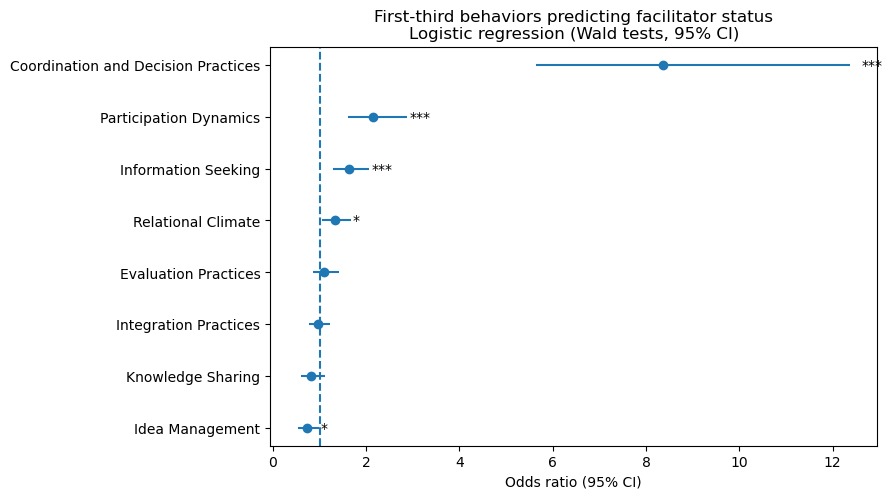

In [26]:
import os, json, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# -------------------------
# CONFIG (match your earlier settings)
# -------------------------
BASE_DIR = '/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/gemini_data_analysis/data' # same as before
OUTCOME = "is_facilitator"
STANDARDIZE = True  # OR per 1 SD increase

# df_indiv must already exist from your earlier chunk:
# columns: session_id, speaker, + code columns

# -------------------------
# Helpers
# -------------------------
def safe_load_json(path: str):
    with open(path, "r") as f:
        return json.load(f)

def normalize_name(s: str) -> str:
    """Normalize speaker names so outcomes & session speakers match."""
    if s is None:
        return ""
    s = str(s)
    # drop affiliations like "Marcel Schreier - UWisc Madison"
    s = re.split(r"\s+-\s+", s)[0]
    # collapse whitespace and strip
    s = re.sub(r"\s+", " ", s).strip()
    # lowercase for robust matching
    return s.lower()

def is_session_outcomes_file(path: str) -> bool:
    return os.path.basename(path).endswith("_session_outcomes.json")

def extract_session_key(session_id: str) -> str:
    """
    Your df_indiv session_id looks like:
      2020NES__session_data__2020_11_05_NES_S1
    We want the trailing key:
      2020_11_05_NES_S1
    """
    return str(session_id).split("__")[-1]

# -------------------------
# Build: session_key -> set(facilitators)
# -------------------------
outcomes_paths = glob.glob(os.path.join(BASE_DIR, "**", "*_session_outcomes.json"), recursive=True)

sessionkey_to_facilitators = {}
outcomes_loaded = 0

for p in outcomes_paths:
    try:
        obj = safe_load_json(p)
    except Exception:
        continue

    # outcomes file structure: dict keyed by session_key -> dict with 'facilitators'
    if not isinstance(obj, dict):
        continue

    outcomes_loaded += 1

    for session_key, entry in obj.items():
        if not isinstance(entry, dict):
            continue

        facs = entry.get("facilitators", None)
        if facs is None:
            continue

        if isinstance(facs, str):
            fac_list = [facs]
        elif isinstance(facs, list):
            fac_list = facs
        else:
            continue

        fac_norm = {normalize_name(x) for x in fac_list if normalize_name(x)}
        if not fac_norm:
            continue

        sessionkey_to_facilitators.setdefault(session_key, set()).update(fac_norm)

print("=== OUTCOMES LABEL COVERAGE ===")
print("Outcomes files found:", len(outcomes_paths))
print("Outcomes files loaded:", outcomes_loaded)
print("Session keys with facilitator labels:", len(sessionkey_to_facilitators))

# -------------------------
# Attach labels to df_indiv
# -------------------------
df_indiv = df_indiv.copy()
df_indiv["session_key"] = df_indiv["session_id"].apply(extract_session_key)
df_indiv["speaker_norm"] = df_indiv["speaker"].apply(normalize_name)

def label_facilitator(row):
    facs = sessionkey_to_facilitators.get(row["session_key"], None)
    if facs is None:
        return np.nan  # unknown label for this session
    return 1 if row["speaker_norm"] in facs else 0

df_indiv[OUTCOME] = df_indiv.apply(label_facilitator, axis=1)

# Report label join success
n_total = len(df_indiv)
n_labeled = df_indiv[OUTCOME].notna().sum()
n_missing = n_total - n_labeled

print("\n=== LABEL JOIN REPORT ===")
print("Rows in df_indiv:", n_total)
print("Rows with facilitator label:", n_labeled)
print("Rows missing label (session not in outcomes):", n_missing)

# If you want, see which sessions are missing:
if n_missing > 0:
    missing_sessions = df_indiv.loc[df_indiv[OUTCOME].isna(), "session_key"].value_counts().head(20)
    print("\nTop missing session_keys:")
    display(missing_sessions)

# Drop unlabeled rows for modeling
df_model = df_indiv.dropna(subset=[OUTCOME]).copy()
df_model[OUTCOME] = df_model[OUTCOME].astype(int)

print("\n=== Facilitator class balance (labeled rows) ===")
print(df_model[OUTCOME].value_counts())

# -------------------------
# Logistic regression
# -------------------------
feature_cols = [c for c in df_model.columns if c not in ["session_id", "speaker", "session_key", "speaker_norm", OUTCOME]]

X = df_model[feature_cols].astype(float)
y = df_model[OUTCOME].astype(int)

if STANDARDIZE:
    X = (X - X.mean()) / (X.std(ddof=0).replace(0, np.nan))
    X = X.fillna(0.0)

X = sm.add_constant(X)

model = sm.Logit(y, X)
res = model.fit(disp=False)

beta = res.params
se = res.bse
pvals = res.pvalues

OR = np.exp(beta)
CI_low = np.exp(beta - 1.96 * se)
CI_high = np.exp(beta + 1.96 * se)

out = (
    pd.DataFrame({
        "feature": beta.index,
        "beta": beta.values,
        "se": se.values,
        "p": pvals.values,
        "OR": OR.values,
        "CI_low": CI_low.values,
        "CI_high": CI_high.values,
    })
    .query("feature != 'const'")
    .sort_values("OR", ascending=True)
    .reset_index(drop=True)
)

out["sig_95CI"] = ~((out["CI_low"] <= 1.0) & (out["CI_high"] >= 1.0))

print("\n=== Logistic regression results (odds ratios) ===")
display(out[["feature", "OR", "CI_low", "CI_high", "p", "sig_95CI"]])

# -------------------------
# Forest plot
# -------------------------
fig_h = max(4, 0.45 * len(out) + 1.5)
plt.figure(figsize=(9, fig_h))

ypos = np.arange(len(out))
plt.hlines(y=ypos, xmin=out["CI_low"], xmax=out["CI_high"])
plt.plot(out["OR"], ypos, "o")
plt.axvline(1.0, linestyle="--")

plt.yticks(ypos, out["feature"])
plt.xlabel("Odds ratio (95% CI)")
plt.title("First-third behaviors predicting facilitator status\nLogistic regression (Wald tests, 95% CI)")

for i, row in out.iterrows():
    if row["p"] < 0.001:
        star = "***"
    elif row["p"] < 0.01:
        star = "**"
    elif row["p"] < 0.05:
        star = "*"
    else:
        star = ""
    if star:
        plt.text(row["CI_high"] * 1.02, i, star, va="center")

plt.tight_layout()
plt.show()

In [27]:
# assuming you already have:
#   res = statsmodels Logit (or GLM Binomial) fitted result

import pandas as pd
import numpy as np

summary = pd.DataFrame({
    "coef": res.params,
    "se": res.bse,
    "z": res.tvalues,          # Wald z-stat
    "p": res.pvalues,          # Wald p-value
    "OR": np.exp(res.params),
    "CI_low": np.exp(res.conf_int()[0]),
    "CI_high": np.exp(res.conf_int()[1]),
})

# drop intercept if you want
summary = summary.drop(index=[i for i in summary.index if "Intercept" in str(i) or "const" in str(i)], errors="ignore")

summary = summary.sort_values("p")
display(summary)

,coef,se,z,p,OR,CI_low,CI_high
Coordination and Decision Practices,2.123007,0.200017,10.614148,2.561196e-26,8.356224,5.646191,12.367007
Participation Dynamics,0.767752,0.147177,5.216522,1.823138e-07,2.154917,1.614928,2.875463
Information Seeking,0.489249,0.120563,4.058033,4.948774e-05,1.631092,1.287819,2.065865
Relational Climate,0.279898,0.119391,2.344388,1.905833e-02,1.322995,1.046966,1.671797
Idea Management,-0.318995,0.160941,-1.982060,4.747251e-02,0.726879,0.530236,0.996450
Knowledge Sharing,-0.200380,0.159726,-1.254529,2.096498e-01,0.818419,0.598435,1.119269
Evaluation Practices,0.093874,0.130639,0.718579,4.724005e-01,1.098422,0.850294,1.418957
Integration Practices,-0.023406,0.115228,-0.203125,8.390370e-01,0.976866,0.779385,1.224384


In [28]:
# feature columns (exclude obvious id columns)
id_cols = {"session_id", "speaker", "session_key", "speaker_norm", "is_facilitator"}
code_cols = [c for c in df_indiv.columns if c not in id_cols]

# force numeric; non-numeric -> NaN
Xnum = df_indiv[code_cols].apply(pd.to_numeric, errors="coerce")

# now these work
print("Top max values:")
print(Xnum.max().sort_values(ascending=False).head(10))

sample = Xnum.stack().dropna()
print("\nFraction near-integers:")
print((np.isclose(sample, np.round(sample))).mean())

print("\nNon-numeric columns that got coerced (had NaNs after coercion):")
bad = Xnum.isna().any()
print(bad[bad].index.tolist())

Top max values:
code
Knowledge Sharing                      12.250000
Coordination and Decision Practices     8.566667
Relational Climate                      7.516667
Participation Dynamics                  7.333333
Idea Management                         7.050000
Evaluation Practices                    5.666667
Information Seeking                     4.866667
Integration Practices                   3.000000
dtype: float64

Fraction near-integers:
0.5379917512690355

Non-numeric columns that got coerced (had NaNs after coercion):
[]


## Slide 5 - First Part

Found outcome files: 8
Outcomes files loaded: 8
Sessions with teams: 123
Unique people with team membership: 219
Member->team links added: 310

=== df_feat built (person x session) ===
df_feat shape: (1576, 10)


code,session_id,speaker,Coordination and Decision Practices,Evaluation Practices,Idea Management,Information Seeking,Integration Practices,Knowledge Sharing,Participation Dynamics,Relational Climate
0,2020NES__session_data__2020_11_05_NES_S1,Alissa Park,6.183333,1.083333,3.883333,2.533333,0.0,9.333333,0.000000,0.883333
1,2020NES__session_data__2020_11_05_NES_S1,Chris Gorski,0.000000,0.000000,0.000000,0.000000,0.0,0.116667,0.000000,0.000000
2,2020NES__session_data__2020_11_05_NES_S1,Emily Ryan,0.000000,0.950000,0.366667,0.783333,0.0,1.366667,0.000000,0.166667
3,2020NES__session_data__2020_11_05_NES_S1,Fateme Rezaei,0.000000,0.000000,0.000000,0.833333,0.0,0.916667,0.833333,0.000000
4,2020NES__session_data__2020_11_05_NES_S1,Gary Moore,0.000000,0.000000,0.400000,0.166667,0.0,0.400000,0.000000,0.000000



=== Outcome counts (on_team_any) ===
on_team_any
0    765
1    811
Name: count, dtype: int64
Positive rate: 0.5145939086294417
Sanity: matches in first 200 speakers: 112

=== Slide 5 sanity checks ===
Rows used: 1576
Num features: 8

=== Slide 5 results (ridge OR per 1 SD; bootstrap 95% CI) ===


,OR,CI_low,CI_high,CI_excludes_1
Knowledge Sharing,1.228040,1.031264,1.519356,True
Information Seeking,1.106260,0.970228,1.286359,False
Evaluation Practices,1.067991,0.915688,1.254585,False
Idea Management,1.061690,0.900555,1.264676,False
Integration Practices,1.044251,0.937473,1.179101,False
Relational Climate,1.028070,0.884511,1.202208,False
Participation Dynamics,0.615298,0.429126,0.787473,True
Coordination and Decision Practices,0.339273,0.235845,0.456850,True


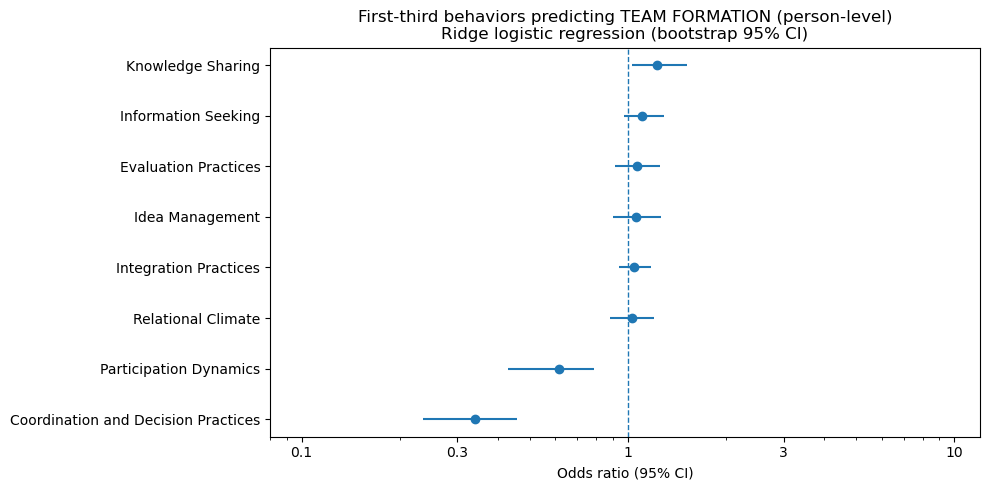

In [29]:
# ============================================================
# SLIDE 5 (UPDATED): Person-level TEAM FORMATION
# Uses df_long (from your "Slide 4" person-level build)
# Builds PERSON_TO_TEAM from ALL *_session_outcomes.json (across conferences)
# Creates on_team_any correctly (name-normalized lookup)
# Ridge logistic + stratified bootstrap OR CIs + forest plot
# ============================================================

import os, glob, json, re
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from matplotlib.ticker import FixedLocator, FuncFormatter

# -------------------------
# CONFIG
# -------------------------
BASE_DIR = "/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/gemini_data_analysis/data"

DF_LONG_NAME = "df_long"   # must exist
VALUE_COL = "value"        # minutes if USE_TIME=True, else counts
OUTCOME_COL = "on_team_any"

C_VAL = 1.0
N_BOOT = 1000
RNG_SEED = 0

# -------------------------
# Helpers
# -------------------------
def normalize_name(s: str) -> str:
    """Normalize names for robust matching between outcomes roster and speakers."""
    if s is None:
        return ""
    s = str(s)
    s = re.split(r"\s+-\s+", s)[0]          # drop affiliations like "Name - Uni"
    s = re.sub(r"\s+", " ", s).strip()      # collapse whitespace
    return s.lower()

def safe_load_json(path: str):
    with open(path, "r") as f:
        return json.load(f)

# -------------------------
# 1) Build PERSON_TO_TEAM from ALL session_outcomes
# -------------------------
outcome_paths = glob.glob(os.path.join(BASE_DIR, "**", "*_session_outcomes.json"), recursive=True)
print("Found outcome files:", len(outcome_paths))

PERSON_TO_TEAM = defaultdict(set)

files_loaded = 0
sessions_with_teams = 0
members_added = 0

for path in outcome_paths:
    try:
        outcomes = safe_load_json(path)
    except Exception:
        continue
    if not isinstance(outcomes, dict):
        continue

    files_loaded += 1

    for session_key, entry in outcomes.items():
        if not isinstance(entry, dict):
            continue

        teams = entry.get("teams", None)
        if not isinstance(teams, dict) or len(teams) == 0:
            continue

        sessions_with_teams += 1

        for team_id, team_info in teams.items():
            if not isinstance(team_info, dict):
                continue
            members = team_info.get("members", [])
            if not isinstance(members, list):
                continue

            for m in members:
                nm = normalize_name(m)
                if nm:
                    before = len(PERSON_TO_TEAM[nm])
                    PERSON_TO_TEAM[nm].add(str(team_id))
                    after = len(PERSON_TO_TEAM[nm])
                    if after > before:
                        members_added += 1

# freeze to plain dict (nice for printing/debug)
PERSON_TO_TEAM = dict(PERSON_TO_TEAM)

print("Outcomes files loaded:", files_loaded)
print("Sessions with teams:", sessions_with_teams)
print("Unique people with team membership:", len(PERSON_TO_TEAM))
print("Member->team links added:", members_added)

# -------------------------
# 2) Build df_feat (person x session wide) from df_long
# -------------------------
if DF_LONG_NAME not in globals():
    raise NameError(f"{DF_LONG_NAME} not found. Run the df_long construction cell first.")

df_long_local = globals()[DF_LONG_NAME].copy()

required = {"session_id", "speaker", "code", VALUE_COL}
missing = required - set(df_long_local.columns)
if missing:
    raise ValueError(f"{DF_LONG_NAME} missing {missing}. Has: {list(df_long_local.columns)}")

df_long_local["speaker"] = df_long_local["speaker"].astype(str).str.strip()
df_long_local["code"] = df_long_local["code"].astype(str).str.strip()
df_long_local = df_long_local[(df_long_local["speaker"] != "") & (df_long_local["code"] != "")].copy()

df_ps = (
    df_long_local
    .groupby(["session_id", "speaker", "code"], as_index=False)[VALUE_COL]
    .sum()
)

df_feat = (
    df_ps
    .pivot_table(index=["session_id", "speaker"], columns="code", values=VALUE_COL, fill_value=0.0)
    .reset_index()
)

print("\n=== df_feat built (person x session) ===")
print("df_feat shape:", df_feat.shape)
display(df_feat.head())

# -------------------------
# 3) Create on_team_any (CORRECT: normalize df_feat speakers before lookup)
# -------------------------
def person_on_team_any(person_name: str) -> int:
    key = normalize_name(person_name)
    team_ids = PERSON_TO_TEAM.get(key, set())
    return int(len(team_ids) > 0)

df_feat[OUTCOME_COL] = df_feat["speaker"].apply(person_on_team_any).astype(int)

vc = df_feat[OUTCOME_COL].value_counts().sort_index()
print("\n=== Outcome counts (on_team_any) ===")
print(vc)
print("Positive rate:", float(df_feat[OUTCOME_COL].mean()))

# Quick matching sanity check
sample_n = min(200, len(df_feat))
hits = sum(normalize_name(s) in PERSON_TO_TEAM for s in df_feat["speaker"].head(sample_n))
print(f"Sanity: matches in first {sample_n} speakers:", hits)

if df_feat[OUTCOME_COL].nunique() < 2:
    raise ValueError(
        "Degenerate outcome: everyone is on a team or no one is.\n"
        "This usually means outcomes 'teams/members' names don't match df_long speakers.\n"
        "Check the 'hits' sanity print and inspect normalize_name rules."
    )

# -------------------------
# 4) Build X/y
# -------------------------
DROP_COLS = {"session_id", "speaker", OUTCOME_COL}
FEATURES = [c for c in df_feat.columns if c not in DROP_COLS]

X_df = df_feat[FEATURES].apply(pd.to_numeric, errors="coerce").fillna(0.0)

# drop constant columns
zero_var = [c for c in X_df.columns if np.isclose(X_df[c].var(ddof=0), 0.0)]
if zero_var:
    X_df = X_df.drop(columns=zero_var)
    FEATURES = [c for c in FEATURES if c not in zero_var]

X = X_df.values
y = df_feat[OUTCOME_COL].values

print("\n=== Slide 5 sanity checks ===")
print("Rows used:", len(y))
print("Num features:", len(FEATURES))

# -------------------------
# 5) Ridge logistic (OR per 1 SD increase because StandardScaler)
# -------------------------
ridge = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    LogisticRegression(
        penalty="l2",
        C=C_VAL,
        solver="lbfgs",
        max_iter=5000,
        class_weight="balanced",
        random_state=RNG_SEED,
    )
)
ridge.fit(X, y)

OR_point = np.exp(ridge.named_steps["logisticregression"].coef_.ravel())

# -------------------------
# 6) Stratified bootstrap OR CIs
# -------------------------
rng = np.random.default_rng(RNG_SEED)

idx_pos = np.where(y == 1)[0]
idx_neg = np.where(y == 0)[0]
n_pos, n_neg = len(idx_pos), len(idx_neg)

boot_or = np.zeros((N_BOOT, len(FEATURES)), dtype=float)

for b in range(N_BOOT):
    samp_idx = np.concatenate([
        rng.choice(idx_pos, size=n_pos, replace=True),
        rng.choice(idx_neg, size=n_neg, replace=True),
    ])

    Xb, yb = X[samp_idx], y[samp_idx]

    mb = make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        LogisticRegression(
            penalty="l2",
            C=C_VAL,
            solver="lbfgs",
            max_iter=5000,
            class_weight="balanced",
            random_state=RNG_SEED,
        )
    )
    mb.fit(Xb, yb)
    boot_or[b, :] = np.exp(mb.named_steps["logisticregression"].coef_.ravel())

CI_low = np.quantile(boot_or, 0.025, axis=0)
CI_high = np.quantile(boot_or, 0.975, axis=0)

out = pd.DataFrame({"OR": OR_point, "CI_low": CI_low, "CI_high": CI_high}, index=FEATURES)
out["CI_excludes_1"] = (out["CI_low"] > 1.0) | (out["CI_high"] < 1.0)
out_sorted = out.sort_values("OR", ascending=False)

print("\n=== Slide 5 results (ridge OR per 1 SD; bootstrap 95% CI) ===")
display(out_sorted)

# -------------------------
# 7) Forest plot
# -------------------------
plot_df = out_sorted.sort_values("OR").copy()
eps = 1e-12
plot_df[["CI_low", "OR", "CI_high"]] = plot_df[["CI_low", "OR", "CI_high"]].clip(lower=eps)

fig_h = max(5, 0.35 * len(plot_df) + 2)
fig, ax = plt.subplots(figsize=(10, fig_h))

ypos = np.arange(len(plot_df))
ax.hlines(y=ypos, xmin=plot_df["CI_low"], xmax=plot_df["CI_high"])
ax.plot(plot_df["OR"], ypos, "o")
ax.axvline(1.0, linestyle="--", linewidth=1)

ax.set_xscale("log")
ax.set_xlim(0.08, 12)
tick_vals = [0.1, 0.3, 1, 3, 10]
ax.xaxis.set_major_locator(FixedLocator(tick_vals))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:g}"))

ax.set_yticks(ypos)
ax.set_yticklabels(plot_df.index)
ax.set_xlabel("Odds ratio (95% CI)")
ax.set_title("First-third behaviors predicting TEAM FORMATION (person-level)\nRidge logistic regression (bootstrap 95% CI)")

plt.tight_layout()
plt.show()

In [30]:
# ============================================================
# SLIDE 5B (FIX): rebuild X and y from df_feat (same rows),
# refit ridge on DataFrame, then compute approximate Wald p-values
# ============================================================

import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

OUTCOME_COL = "on_team_any"   # Slide 5 outcome

# 1) Rebuild the EXACT feature list the model should use
DROP_COLS = {"session_id", "speaker", OUTCOME_COL}
FEATURES = [c for c in df_feat.columns if c not in DROP_COLS]

X_df = df_feat[FEATURES].apply(pd.to_numeric, errors="coerce").fillna(0.0)

# drop constant columns (must match what you do in the main Slide 5 fit)
zero_var = [c for c in X_df.columns if np.isclose(X_df[c].var(ddof=0), 0.0)]
if zero_var:
    X_df = X_df.drop(columns=zero_var)
    FEATURES = [c for c in FEATURES if c not in zero_var]

# 2) Rebuild y from df_feat (same row count)
y = df_feat[OUTCOME_COL].astype(int).values

print("X shape:", X_df.shape, "| y shape:", y.shape)
print("Outcome counts:\n", pd.Series(y).value_counts().sort_index())

# 3) Fit ridge using DataFrame (keeps feature names)
ridge_df = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    LogisticRegression(
        penalty="l2",
        C=C_VAL,
        solver="lbfgs",
        max_iter=5000,
        class_weight="balanced",
        random_state=RNG_SEED,
    )
)
ridge_df.fit(X_df, y)

# 4) Wald-style p-values (approx)
coef = ridge_df.named_steps["logisticregression"].coef_.ravel()
X_std = ridge_df.named_steps["standardscaler"].transform(X_df)
p_hat = ridge_df.predict_proba(X_df)[:, 1]

w = p_hat * (1 - p_hat)
XtWX = X_std.T @ (X_std * w[:, None])

lambda_ridge = 1.0 / C_VAL
XtWX_pen = XtWX + lambda_ridge * np.eye(XtWX.shape[0])
cov_beta = np.linalg.inv(XtWX_pen)
se = np.sqrt(np.diag(cov_beta))

z = coef / se
p = 2 * (1 - stats.norm.cdf(np.abs(z)))

wald_df = pd.DataFrame(
    {"OR": np.exp(coef), "z": z, "p_value": p},
    index=X_df.columns
).sort_values("OR", ascending=False)

wald_df["sig_p05"] = wald_df["p_value"] < 0.05

print("\n=== Slide 5 Wald p-values (approx; ridge logistic) ===")
display(wald_df)

X shape: (1576, 8) | y shape: (1576,)
Outcome counts:
 0    765
1    811
Name: count, dtype: int64

=== Slide 5 Wald p-values (approx; ridge logistic) ===


,OR,z,p_value,sig_p05
code,,,,
Knowledge Sharing,1.228040,2.237408,2.525968e-02,True
Information Seeking,1.106260,1.487511,1.368799e-01,False
Evaluation Practices,1.067991,0.969395,3.323482e-01,False
Idea Management,1.061690,0.686822,4.921949e-01,False
Integration Practices,1.044251,0.676860,4.984947e-01,False
Relational Climate,1.028070,0.384325,7.007375e-01,False
Participation Dynamics,0.615298,-4.001319,6.299025e-05,True
Coordination and Decision Practices,0.339273,-7.344343,2.067235e-13,True


## Slide 6

In [31]:
# ============================================================
# SLIDE 4 (REBUILD): Create person-level long df for Slide 6A
# Produces: df_long_person with columns:
#   session_id, speaker, when, code, value
# ============================================================

import pandas as pd
import numpy as np

# --- pick the best existing person x session wide df in memory ---
# You said you have df_feat already from Slide 5 (person x session).
# If not, this will search for a df that has session_id + speaker and multiple code columns.

def find_person_wide_df():
    snap = list(globals().items())
    cands = []
    for name, obj in snap:
        if isinstance(obj, pd.DataFrame):
            cols = set(obj.columns)
            if {"session_id", "speaker"}.issubset(cols):
                # heuristic: at least 5 behavior columns
                non_id = cols - {"session_id", "speaker", "session_key", "speaker_norm", "is_facilitator", "when"}
                if len(non_id) >= 5:
                    cands.append((name, len(non_id)))
    cands = sorted(cands, key=lambda x: x[1], reverse=True)
    return cands

cands = find_person_wide_df()
print("Person-wide candidates:", cands[:5])

if "df_feat" in globals() and isinstance(globals()["df_feat"], pd.DataFrame) and {"session_id","speaker"}.issubset(globals()["df_feat"].columns):
    wide = globals()["df_feat"].copy()
    src_name = "df_feat"
elif len(cands) > 0:
    src_name = cands[0][0]
    wide = globals()[src_name].copy()
else:
    raise ValueError(
        "Couldn't find a person-level wide dataframe (needs session_id + speaker + behavior columns).\n"
        "If you previously built df_feat (person x session) for Slide 5, re-run that cell first."
    )

print(f"Using person-wide df: {src_name} | shape={wide.shape}")

# --- ensure a 'when' column exists (since Slide 6A filters WHEN_FILTER) ---
# If you only have beginning-third features in this df already, label it as 'beginning'.
if "when" not in wide.columns:
    wide["when"] = "beginning"

# --- melt wide -> long ---
id_cols = ["session_id", "speaker", "when"]
drop_cols = {"session_key", "speaker_norm", "is_facilitator"}  # ignore metadata if present
value_vars = [c for c in wide.columns if c not in set(id_cols) and c not in drop_cols]

df_long_person = wide.melt(
    id_vars=id_cols,
    value_vars=value_vars,
    var_name="code",
    value_name="value"
)

df_long_person["code"] = df_long_person["code"].astype(str).str.strip()
df_long_person["speaker"] = df_long_person["speaker"].astype(str).str.strip()
df_long_person["value"] = pd.to_numeric(df_long_person["value"], errors="coerce").fillna(0.0)

print("Built df_long_person:", df_long_person.shape)
display(df_long_person.head())

# leave it in globals for Slide 6A

Person-wide candidates: [('df_labeled', 10), ('df_raw', 10), ('df_feat', 9), ('df_indiv', 8), ('df_model', 8)]
Using person-wide df: df_feat | shape=(1576, 11)
Built df_long_person: (14184, 5)


,session_id,speaker,when,code,value
0,2020NES__session_data__2020_11_05_NES_S1,Alissa Park,beginning,Coordination and Decision Practices,6.183333
1,2020NES__session_data__2020_11_05_NES_S1,Chris Gorski,beginning,Coordination and Decision Practices,0.000000
2,2020NES__session_data__2020_11_05_NES_S1,Emily Ryan,beginning,Coordination and Decision Practices,0.000000
3,2020NES__session_data__2020_11_05_NES_S1,Fateme Rezaei,beginning,Coordination and Decision Practices,0.000000
4,2020NES__session_data__2020_11_05_NES_S1,Gary Moore,beginning,Coordination and Decision Practices,0.000000


=== df_feat built (PERSON x SESSION) ===
df_feat shape: (1576, 11)


code,session_id,speaker,Coordination and Decision Practices,Evaluation Practices,Idea Management,Information Seeking,Integration Practices,Knowledge Sharing,Participation Dynamics,Relational Climate,on_team_any
0,2020NES__session_data__2020_11_05_NES_S1,Alissa Park,6.183333,1.083333,3.883333,2.533333,0.0,9.333333,0.000000,0.883333,0.0
1,2020NES__session_data__2020_11_05_NES_S1,Chris Gorski,0.000000,0.000000,0.000000,0.000000,0.0,0.116667,0.000000,0.000000,1.0
2,2020NES__session_data__2020_11_05_NES_S1,Emily Ryan,0.000000,0.950000,0.366667,0.783333,0.0,1.366667,0.000000,0.166667,1.0
3,2020NES__session_data__2020_11_05_NES_S1,Fateme Rezaei,0.000000,0.000000,0.000000,0.833333,0.0,0.916667,0.833333,0.000000,0.0
4,2020NES__session_data__2020_11_05_NES_S1,Gary Moore,0.000000,0.000000,0.400000,0.166667,0.0,0.400000,0.000000,0.000000,1.0



Found outcome files: 8
Session keys with funded label: 123
Funding key usage:
  funded_status: 123

=== Join report ===
Rows in df_feat: 1576
Rows with label: 1245
Rows missing label: 331

Outcome counts (funded_any):
funded_any
0    786
1    459
Name: count, dtype: int64
Positive rate: 0.3686746987951807

=== Slide 6A results (INDIVIDUAL-level; ridge OR per 1 SD; bootstrap 95% CI) ===


,OR,CI_low,CI_high,CI_excludes_1
Idea Management,1.342519,1.138565,1.638292,True
Relational Climate,1.070830,0.933752,1.226997,False
Information Seeking,1.044539,0.910603,1.196013,False
Integration Practices,1.011896,0.886612,1.139828,False
on_team_any,1.003458,0.889879,1.127688,False
Coordination and Decision Practices,0.958964,0.784991,1.148349,False
Participation Dynamics,0.952307,0.779276,1.131730,False
Evaluation Practices,0.923082,0.793611,1.059208,False
Knowledge Sharing,0.864201,0.702262,1.031497,False


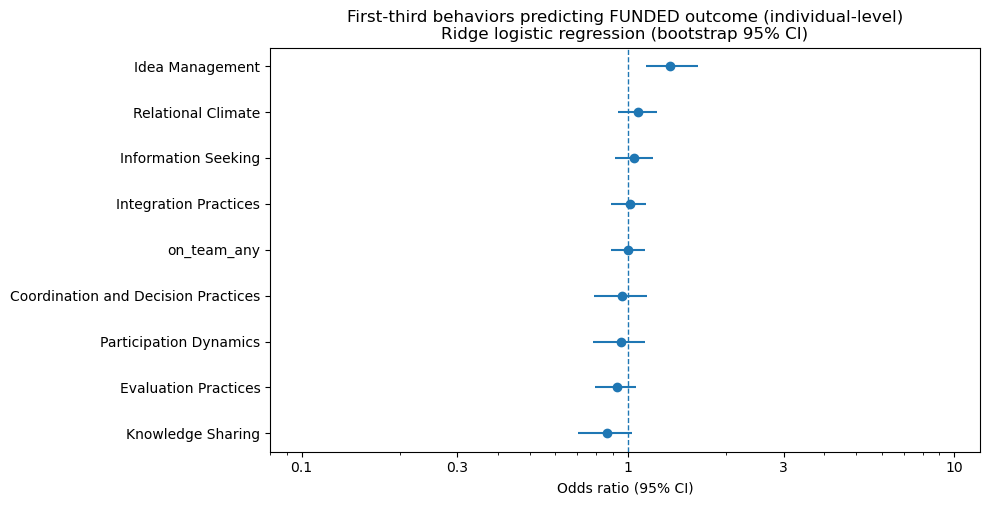


(df_labeled is INDIVIDUAL-level and defined.)


In [32]:
# ============================================================
# SLIDE 6A (INDIVIDUAL-LEVEL): FUNDING outcome
# - Uses df_long_person: ['session_id','speaker','when','code','value']
# - Loads funding labels from *_session_outcomes.json (key: funded_status)
# - Joins session funding onto each person-row
# - Ridge logistic + stratified bootstrap OR CIs + forest plot
# ============================================================

import os, glob, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from matplotlib.ticker import FixedLocator, FuncFormatter

# ----------------------------
# CONFIG
# ----------------------------
BASE_DIR = "/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/gemini_data_analysis/data"

WHEN_FILTER = "beginning"
OUTCOME_COL = "funded_any"
C_VAL = 1.0
N_BOOT = 1000
RNG_SEED = 0

IGNORE_CODES = {"None", "Other", ""}

FUNDING_KEYS = [
    "funded_status",  # <-- your schema key
    "funded_any", "funded", "is_funded", "funding",
    "outcome_funded", "proposal_funded", "successful", "success"
]

# ----------------------------
# Helpers
# ----------------------------
def safe_load_json(path: str):
    with open(path, "r") as f:
        return json.load(f)

def extract_session_key(session_id: str) -> str:
    return str(session_id).split("__")[-1]

def normalize_to_binary(val):
    if val is None:
        return None
    if isinstance(val, bool):
        return int(val)
    if isinstance(val, (int, float)) and np.isfinite(val):
        return int(val != 0)
    if isinstance(val, str):
        v = val.strip().lower()
        if v in {"funded","yes","y","true","successful","success","1"}:
            return 1
        if v in {"not funded","no","n","false","unsuccessful","fail","0"}:
            return 0
    return None

def find_first_key_recursive(obj, keys):
    if isinstance(obj, dict):
        for k in keys:
            if k in obj:
                return k, obj.get(k)
        for v in obj.values():
            fk, fv = find_first_key_recursive(v, keys)
            if fk is not None:
                return fk, fv
    elif isinstance(obj, list):
        for item in obj:
            fk, fv = find_first_key_recursive(item, keys)
            if fk is not None:
                return fk, fv
    return None, None

# ----------------------------
# 0) Input: df_long_person must exist
# ----------------------------
if "df_long_person" not in globals():
    raise NameError("df_long_person not found. Run your person-level rebuild/melt cell first.")

df_long_local = df_long_person.copy()

required = {"session_id","speaker","when","code","value"}
missing = required - set(df_long_local.columns)
if missing:
    raise ValueError(f"df_long_person missing {missing}. Has: {list(df_long_local.columns)}")

# clean + filter
df_long_local["speaker"] = df_long_local["speaker"].astype(str).str.strip()
df_long_local["code"] = df_long_local["code"].astype(str).str.strip()

df_long_local = df_long_local[(df_long_local["speaker"] != "") & (df_long_local["code"] != "")].copy()
df_long_local = df_long_local[~df_long_local["code"].isin(IGNORE_CODES)].copy()

df_first = df_long_local[df_long_local["when"] == WHEN_FILTER].copy()
if df_first.empty:
    raise ValueError(f"No rows for when == '{WHEN_FILTER}'. Check df_long_person['when']: {df_long_local['when'].unique()}")

# person-session-code aggregate -> PERSON x SESSION wide
df_ps = (
    df_first
    .groupby(["session_id","speaker","code"], as_index=False)["value"]
    .sum()
)

df_feat = (
    df_ps
    .pivot_table(index=["session_id","speaker"], columns="code", values="value", fill_value=0.0)
    .reset_index()
)

print("=== df_feat built (PERSON x SESSION) ===")
print("df_feat shape:", df_feat.shape)
display(df_feat.head())

# ----------------------------
# 1) Load funding labels (session-level) from outcomes JSONs
# ----------------------------
outcome_paths = glob.glob(os.path.join(BASE_DIR, "**", "*_session_outcomes.json"), recursive=True)
print("\nFound outcome files:", len(outcome_paths))

sessionkey_to_funded = {}
key_hits = {k: 0 for k in FUNDING_KEYS}

for path in outcome_paths:
    try:
        outcomes = safe_load_json(path)
    except Exception:
        continue
    if not isinstance(outcomes, dict):
        continue

    for session_key, entry in outcomes.items():
        if not isinstance(entry, dict):
            continue

        found_key, found_val = find_first_key_recursive(entry, FUNDING_KEYS)
        if found_key is None:
            continue

        b = normalize_to_binary(found_val)
        if b is None:
            continue

        key_hits[found_key] += 1
        sessionkey_to_funded[str(session_key)] = int(b)

print("Session keys with funded label:", len(sessionkey_to_funded))
print("Funding key usage:")
for k, v in sorted(key_hits.items(), key=lambda kv: kv[1], reverse=True):
    if v:
        print(f"  {k}: {v}")

if len(sessionkey_to_funded) == 0:
    raise ValueError("No funded labels extracted. Confirm outcomes schema / keys.")

# ----------------------------
# 2) Join funding onto each person-row (via session_key)
# ----------------------------
df_labeled = df_feat.copy()
df_labeled["session_key"] = df_labeled["session_id"].apply(extract_session_key)
df_labeled[OUTCOME_COL] = df_labeled["session_key"].map(sessionkey_to_funded)

print("\n=== Join report ===")
print("Rows in df_feat:", len(df_feat))
print("Rows with label:", int(df_labeled[OUTCOME_COL].notna().sum()))
print("Rows missing label:", int(df_labeled[OUTCOME_COL].isna().sum()))

df_labeled = df_labeled.dropna(subset=[OUTCOME_COL]).copy()
df_labeled[OUTCOME_COL] = df_labeled[OUTCOME_COL].astype(int)

print("\nOutcome counts (funded_any):")
print(df_labeled[OUTCOME_COL].value_counts().sort_index())
print("Positive rate:", float(df_labeled[OUTCOME_COL].mean()))

if df_labeled[OUTCOME_COL].nunique() < 2:
    raise ValueError("Degenerate outcome after join (only one class). Can't fit model.")

# ----------------------------
# 3) Ridge logistic + stratified bootstrap OR CIs
# ----------------------------
DROP_COLS = {"session_id","session_key","speaker",OUTCOME_COL}
FEATURES = [c for c in df_labeled.columns if c not in DROP_COLS]

X_df = df_labeled[FEATURES].apply(pd.to_numeric, errors="coerce").fillna(0.0)
zero_var = [c for c in X_df.columns if np.isclose(X_df[c].var(ddof=0), 0.0)]
if zero_var:
    X_df = X_df.drop(columns=zero_var)
    FEATURES = [c for c in FEATURES if c not in zero_var]

X = X_df.values
y = df_labeled[OUTCOME_COL].values

ridge = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        class_weight="balanced",
        C=C_VAL,
        max_iter=5000,
        random_state=RNG_SEED,
    )
)
ridge.fit(X, y)
OR_point = np.exp(ridge.named_steps["logisticregression"].coef_.ravel())

rng = np.random.default_rng(RNG_SEED)
idx_pos = np.where(y == 1)[0]
idx_neg = np.where(y == 0)[0]

boot_or = np.zeros((N_BOOT, len(FEATURES)), dtype=float)
for b in range(N_BOOT):
    samp_idx = np.concatenate([
        rng.choice(idx_pos, size=len(idx_pos), replace=True),
        rng.choice(idx_neg, size=len(idx_neg), replace=True),
    ])
    Xb, yb = X[samp_idx], y[samp_idx]

    mb = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            penalty="l2",
            solver="lbfgs",
            class_weight="balanced",
            C=C_VAL,
            max_iter=5000,
            random_state=RNG_SEED,
        )
    )
    mb.fit(Xb, yb)
    boot_or[b] = np.exp(mb.named_steps["logisticregression"].coef_.ravel())

CI_low = np.quantile(boot_or, 0.025, axis=0)
CI_high = np.quantile(boot_or, 0.975, axis=0)

results = pd.DataFrame({"OR": OR_point, "CI_low": CI_low, "CI_high": CI_high}, index=FEATURES)
results["CI_excludes_1"] = (results["CI_low"] > 1.0) | (results["CI_high"] < 1.0)
results = results.sort_values("OR", ascending=False)

print("\n=== Slide 6A results (INDIVIDUAL-level; ridge OR per 1 SD; bootstrap 95% CI) ===")
display(results)

# ----------------------------
# 4) Forest plot
# ----------------------------
plot_df = results.sort_values("OR").copy()
eps = 1e-12
plot_df[["OR","CI_low","CI_high"]] = plot_df[["OR","CI_low","CI_high"]].clip(lower=eps)

fig_h = max(5, 0.35 * len(plot_df) + 2)
fig, ax = plt.subplots(figsize=(10, fig_h))
ypos = np.arange(len(plot_df))

ax.hlines(y=ypos, xmin=plot_df["CI_low"], xmax=plot_df["CI_high"])
ax.plot(plot_df["OR"], ypos, "o")
ax.axvline(1.0, linestyle="--", linewidth=1)

ax.set_xscale("log")
ax.set_xlim(0.08, 12)
tick_vals = [0.1, 0.3, 1, 3, 10]
ax.xaxis.set_major_locator(FixedLocator(tick_vals))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:g}"))

ax.set_yticks(ypos)
ax.set_yticklabels(plot_df.index)
ax.set_xlabel("Odds ratio (95% CI)")
ax.set_title("First-third behaviors predicting FUNDED outcome (individual-level)\nRidge logistic regression (bootstrap 95% CI)")

plt.tight_layout()
plt.show()

print("\n(df_labeled is INDIVIDUAL-level and defined.)")

In [33]:
# ============================================================
# SLIDE 6A (REFERENCE ONLY):
# Plain, unpenalized logistic regression Wald p-values (unstable under imbalance)
# - Uses the SAME predictors as your ridge model (FEATURES)
# - Standardizes predictors (OR per 1 SD)
# - Drops missing rows ONCE (aligned X/y)
# ============================================================

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm

# --- assumes you already ran Slide 6A above and have:
# df_labeled, OUTCOME_COL, FEATURES

# 1) Build X and y from the same objects used in ridge
X_df = df_labeled[FEATURES].apply(pd.to_numeric, errors="coerce")
y_s  = df_labeled[OUTCOME_COL].astype(int)

# 2) Standardize X (per 1 SD increase)
X_std = (X_df - X_df.mean(axis=0)) / X_df.std(axis=0, ddof=0)
X_std = X_std.replace([np.inf, -np.inf], np.nan)

# 3) Align and drop missing ONCE
dat = pd.concat([y_s.rename("y"), X_std], axis=1).dropna(axis=0).copy()
y_aligned = dat["y"].astype(int)
X_aligned = dat.drop(columns=["y"])

# 4) Drop constant/near-constant columns (Logit hates them)
const_cols = [c for c in X_aligned.columns if np.isclose(X_aligned[c].var(ddof=0), 0.0)]
if const_cols:
    print("Dropping constant columns for plain Logit:", const_cols)
    X_aligned = X_aligned.drop(columns=const_cols)

# 5) Fit plain Logit
X_sm = sm.add_constant(X_aligned, has_constant="add")

# Note: This can throw if there's separation / singular matrix.
# If it fails, that's not your fault: it's the model screaming "use ridge" (which you did).
res = sm.Logit(y_aligned.values, X_sm.values).fit(disp=False, maxiter=300)

# 6) Wald p-values + ORs
coef = pd.Series(res.params, index=X_sm.columns)
se   = pd.Series(res.bse,    index=X_sm.columns)

z = coef / se
p = 2 * (1 - norm.cdf(np.abs(z)))

wald = pd.DataFrame({
    "OR": np.exp(coef),
    "p": p,
    "z": z,
    "CI_low": np.exp(coef - 1.96 * se),
    "CI_high": np.exp(coef + 1.96 * se),
}, index=X_sm.columns)

wald = wald.drop(index="const", errors="ignore").sort_values("p")

print("=== Slide 6A P-values (reference only): plain, unpenalized Logit Wald tests ===")
display(wald)

# Optional: compact list for speaker notes
speaker = wald.copy()
speaker["OR"] = speaker["OR"].astype(float)
speaker["p"] = speaker["p"].astype(float)

print("\nSpeaker-notes format (OR, p):")
for name, row in speaker.iterrows():
    print(f"{name}: OR ≈ {row['OR']:.2f}, p = {row['p']:.3g}")

=== Slide 6A P-values (reference only): plain, unpenalized Logit Wald tests ===


,OR,p,z,CI_low,CI_high
Idea Management,1.343743,0.000777,3.361018,1.131065,1.596410
Knowledge Sharing,0.861599,0.106072,-1.616102,0.719191,1.032207
Evaluation Practices,0.922908,0.260470,-1.125281,0.802550,1.061317
Relational Climate,1.078834,0.285991,1.066957,0.938463,1.240201
Information Seeking,1.041074,0.553700,0.592225,0.911224,1.189429
Coordination and Decision Practices,0.952381,0.618014,-0.498666,0.786190,1.153704
Participation Dynamics,0.957143,0.637352,-0.471404,0.797780,1.148341
Integration Practices,1.010885,0.857906,0.179041,0.897908,1.138076
on_team_any,1.002312,0.970662,0.036778,0.886234,1.133595



Speaker-notes format (OR, p):
Idea Management: OR ≈ 1.34, p = 0.000777
Knowledge Sharing: OR ≈ 0.86, p = 0.106
Evaluation Practices: OR ≈ 0.92, p = 0.26
Relational Climate: OR ≈ 1.08, p = 0.286
Information Seeking: OR ≈ 1.04, p = 0.554
Coordination and Decision Practices: OR ≈ 0.95, p = 0.618
Participation Dynamics: OR ≈ 0.96, p = 0.637
Integration Practices: OR ≈ 1.01, p = 0.858
on_team_any: OR ≈ 1.00, p = 0.971


## Slide 6 - Second Part

Taking in Evey's suggestions to show data "a bit more visually"

(see slide 5 speaker notes w/ Evey)

=== Slide 6B dataset check (SESSION-level) ===
Rows (sessions): 123
Outcome counts (0=unsuccessful, 1=successful):
 0    77
1    46
Name: count, dtype: int64
Success rate: 0.37398373983739835

=== Slide 6B table (for notes) ===


,feature,effect_pct,CI_low,CI_high,sig_95
0,Evaluation Practices,-6.386052,-30.045502,23.215865,False
1,Coordination and Decision Practices,1.667787,-17.650449,23.625078,False
2,Participation Dynamics,2.642732,-19.949348,30.048288,False
3,Knowledge Sharing,5.332529,-7.475945,19.978698,False
4,Relational Climate,9.397099,-11.058386,34.604936,False
5,Information Seeking,13.165232,-9.171214,40.071588,False
6,Idea Management,23.621187,0.989526,50.183575,True
7,Integration Practices,28.307789,-17.084880,97.889575,False


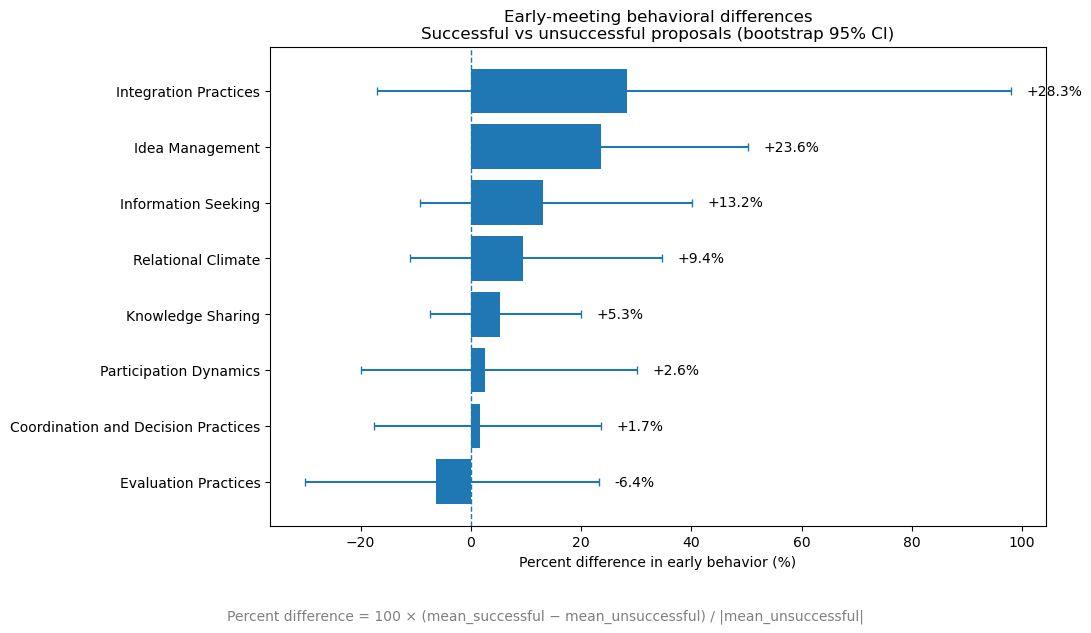

In [34]:
# ============================================================
# SLIDE 6B — Magnitude view (SESSION / PROPOSAL level)
# Early behavioral differences: successful vs unsuccessful proposals
# Percent difference + bootstrap 95% CI
#
# INPUT:
#   df_labeled can be either:
#     - session-level: one row per session_id
#     - individual-level: multiple speakers per session_id
#   -> this cell will collapse to session means if needed.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DF_NAME = "df_labeled"
OUTCOME_COL_CANDIDATES = ["funded_status", "funded_any"]

ANNOTATION_CODES = [
    "Coordination and Decision Practices",
    "Evaluation Practices",
    "Idea Management",
    "Information Seeking",
    "Integration Practices",
    "Knowledge Sharing",
    "Participation Dynamics",
    "Relational Climate",
]

N_BOOT = 2000
RNG_SEED = 0
EPS = 1e-9

# -------------------------
# 1) Load df + pick outcome col
# -------------------------
if DF_NAME not in globals():
    raise NameError(f"{DF_NAME} not found in workspace.")

df_raw = globals()[DF_NAME].copy()

outcome_col = next((c for c in OUTCOME_COL_CANDIDATES if c in df_raw.columns), None)
if outcome_col is None:
    raise ValueError(f"No funded outcome found in {OUTCOME_COL_CANDIDATES}. Columns: {list(df_raw.columns)}")

missing = [c for c in ["session_id", outcome_col] + ANNOTATION_CODES if c not in df_raw.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# -------------------------
# 2) Enforce SESSION-level (collapse if needed)
# -------------------------
# If df_raw has multiple rows per session_id, average behaviors within session.
# Funding outcome is session-level, so it should be identical within session; we take max to be safe.
df = (
    df_raw
    .groupby("session_id", as_index=False)
    .agg({**{c: "mean" for c in ANNOTATION_CODES}, outcome_col: "max"})
)

y = df[outcome_col].astype(int).values
X = df[ANNOTATION_CODES].apply(pd.to_numeric, errors="coerce").fillna(0.0)

print("=== Slide 6B dataset check (SESSION-level) ===")
print("Rows (sessions):", df.shape[0])
print("Outcome counts (0=unsuccessful, 1=successful):\n", pd.Series(y).value_counts().sort_index())
print("Success rate:", float(y.mean()))

X0 = X[y == 0]
X1 = X[y == 1]
if len(X0) < 5 or len(X1) < 5:
    raise ValueError("Not enough sessions per group for stable estimation.")

# -------------------------
# 3) Percent-difference effect
# -------------------------
mean0 = X0.mean(axis=0)
mean1 = X1.mean(axis=0)
effect = 100.0 * (mean1 - mean0) / (mean0.abs() + EPS)

# -------------------------
# 4) Bootstrap 95% CI (resample sessions)
# -------------------------
rng = np.random.default_rng(RNG_SEED)
boot = np.zeros((N_BOOT, len(ANNOTATION_CODES)), dtype=float)

X0_mat = X0.values
X1_mat = X1.values

for b in range(N_BOOT):
    s0 = rng.choice(len(X0_mat), size=len(X0_mat), replace=True)
    s1 = rng.choice(len(X1_mat), size=len(X1_mat), replace=True)

    m0 = X0_mat[s0].mean(axis=0)
    m1 = X1_mat[s1].mean(axis=0)
    boot[b, :] = 100.0 * (m1 - m0) / (np.abs(m0) + EPS)

ci_low = np.quantile(boot, 0.025, axis=0)
ci_high = np.quantile(boot, 0.975, axis=0)

plot_df = (
    pd.DataFrame({
        "feature": ANNOTATION_CODES,
        "effect_pct": effect.values,
        "CI_low": ci_low,
        "CI_high": ci_high,
    })
    .sort_values("effect_pct")
    .reset_index(drop=True)
)

plot_df["sig_95"] = (plot_df["CI_low"] > 0) | (plot_df["CI_high"] < 0)

print("\n=== Slide 6B table (for notes) ===")
display(plot_df)

# -------------------------
# 5) Plot
# -------------------------
ypos = np.arange(len(plot_df))
fig_h = max(3.5, 0.55 * len(plot_df) + 1.5)
fig, ax = plt.subplots(figsize=(11, fig_h))

ax.barh(ypos, plot_df["effect_pct"].values)
ax.errorbar(
    plot_df["effect_pct"].values,
    ypos,
    xerr=[
        plot_df["effect_pct"].values - plot_df["CI_low"].values,
        plot_df["CI_high"].values - plot_df["effect_pct"].values
    ],
    fmt="none",
    capsize=3
)

ax.axvline(0, linestyle="--", linewidth=1)
ax.set_yticks(ypos)
ax.set_yticklabels(plot_df["feature"].values)
ax.set_xlabel("Percent difference in early behavior (%)")
ax.set_title("Early-meeting behavioral differences\nSuccessful vs unsuccessful proposals (bootstrap 95% CI)")

# annotate values
x_min, x_max = ax.get_xlim()
offset = 0.02 * (x_max - x_min)
for i, (val, hi) in enumerate(zip(plot_df["effect_pct"], plot_df["CI_high"])):
    x_text = min(hi + offset, x_max - offset)
    ax.text(x_text, i, f"{val:+.1f}%", va="center")

fig.text(
    0.5, -0.06,
    "Percent difference = 100 × (mean_successful − mean_unsuccessful) / |mean_unsuccessful|",
    ha="center", fontsize=10, color="gray"
)

plt.tight_layout()
plt.show()

### Slide 6B - checking statistical significance

In [35]:
# ============================================================
# SLIDE 6B — Bootstrap significance summary (clean)
# Criterion: 95% bootstrap CI excludes 0
# Optional: bootstrap two-sided sign probability ("p_boot")
# INPUTS REQUIRED:
#   - plot_df with columns: feature, effect_pct, CI_low, CI_high
# ============================================================

import numpy as np
import pandas as pd

required_cols = {"feature", "effect_pct", "CI_low", "CI_high"}
missing = required_cols - set(plot_df.columns)
if missing:
    raise ValueError(f"plot_df missing columns: {missing}. Has: {list(plot_df.columns)}")

sig_df = plot_df.copy()

# 1) CI-excludes-0 significance flag (this is the correct inferential check for 6B)
sig_df["sig_95"] = (sig_df["CI_low"] > 0) | (sig_df["CI_high"] < 0)

# 2) Direction label (helpful for speaker notes)
sig_df["direction"] = np.where(sig_df["effect_pct"] >= 0, "higher in successful", "higher in unsuccessful")

# 3) Optional: bootstrap "two-sided sign probability" (NOT parametric, just a sanity metric)
# If you have the raw bootstrap draws matrix `boot` from the 6B cell, this is useful.
# boot shape should be (N_BOOT, num_features) in the same feature order as ANNOTATION_CODES.
if "boot" in globals():
    # Map boot columns -> features (assumes ANNOTATION_CODES order)
    if "ANNOTATION_CODES" not in globals():
        print("Note: 'boot' found but 'ANNOTATION_CODES' not found; skipping p_boot.")
    else:
        boot_df = pd.DataFrame(boot, columns=ANNOTATION_CODES)
        # two-sided sign probability: 2 * min(P(boot<=0), P(boot>=0))
        p_boot = []
        for feat in sig_df["feature"]:
            if feat in boot_df.columns:
                p0 = (boot_df[feat] <= 0).mean()
                p1 = (boot_df[feat] >= 0).mean()
                p_boot.append(2 * min(p0, p1))
            else:
                p_boot.append(np.nan)
        sig_df["p_boot"] = p_boot

# 4) Nice display table
sig_df_out = sig_df[["feature", "effect_pct", "CI_low", "CI_high", "sig_95", "direction"] + (["p_boot"] if "p_boot" in sig_df.columns else [])]
sig_df_out = sig_df_out.sort_values("effect_pct", ascending=False).reset_index(drop=True)

print("\n=== Slide 6B: Bootstrap significance summary (95% CI excludes 0) ===")
display(sig_df_out)

print("\nSignificant at 95% bootstrap CI (excludes 0):")
display(sig_df_out[sig_df_out["sig_95"] == True][["feature", "effect_pct", "CI_low", "CI_high", "direction"]])


=== Slide 6B: Bootstrap significance summary (95% CI excludes 0) ===


,feature,effect_pct,CI_low,CI_high,sig_95,direction,p_boot
0,Integration Practices,28.307789,-17.084880,97.889575,False,higher in successful,0.276
1,Idea Management,23.621187,0.989526,50.183575,True,higher in successful,0.041
2,Information Seeking,13.165232,-9.171214,40.071588,False,higher in successful,0.244
3,Relational Climate,9.397099,-11.058386,34.604936,False,higher in successful,0.382
4,Knowledge Sharing,5.332529,-7.475945,19.978698,False,higher in successful,0.418
5,Participation Dynamics,2.642732,-19.949348,30.048288,False,higher in successful,0.838
6,Coordination and Decision Practices,1.667787,-17.650449,23.625078,False,higher in successful,0.848
7,Evaluation Practices,-6.386052,-30.045502,23.215865,False,higher in unsuccessful,0.686



Significant at 95% bootstrap CI (excludes 0):


,feature,effect_pct,CI_low,CI_high,direction
1,Idea Management,23.621187,0.989526,50.183575,higher in successful


In [36]:
# ============================================================
# CHECK: Which early behaviors differ the most?
# Descriptive magnitude comparison (SESSION-level)
# Uses summed early behavioral time
# ============================================================

import pandas as pd
import numpy as np

ANNOTATION_CODES = [
    "Coordination and Decision Practices",
    "Evaluation Practices",
    "Idea Management",
    "Information Seeking",
    "Integration Practices",
    "Knowledge Sharing",
    "Participation Dynamics",
    "Relational Climate",
]

OUTCOME_COL = "funded_any"  # or funded_status

# Start from df_labeled (may be individual-level)
df = df_labeled.copy()

# Collapse to SESSION level (funding is session-level)
df_session = (
    df
    .groupby("session_id", as_index=False)
    .agg({**{c: "mean" for c in ANNOTATION_CODES}, OUTCOME_COL: "max"})
)

# Split groups
X_unsuccessful = df_session[df_session[OUTCOME_COL] == 0][ANNOTATION_CODES]
X_successful   = df_session[df_session[OUTCOME_COL] == 1][ANNOTATION_CODES]

# Compute means
mean_unsuccessful = X_unsuccessful.mean()
mean_successful   = X_successful.mean()

# Percent difference (summed early behavior)
percent_diff = 100 * (mean_successful - mean_unsuccessful) / (mean_unsuccessful.abs() + 1e-9)

# Assemble table
check_df = (
    pd.DataFrame({
        "mean_unsuccessful": mean_unsuccessful,
        "mean_successful": mean_successful,
        "percent_diff": percent_diff,
    })
    .sort_values("percent_diff", ascending=False)
)

print("=== Which early behaviors differ the most? (summed time) ===")
display(check_df)

=== Which early behaviors differ the most? (summed time) ===


,mean_unsuccessful,mean_successful,percent_diff
code,,,
Integration Practices,0.086100,0.110472,28.307789
Idea Management,0.729669,0.902025,23.621187
Information Seeking,0.439410,0.497259,13.165232
Relational Climate,0.411709,0.450397,9.397099
Knowledge Sharing,1.401017,1.475727,5.332529
Participation Dynamics,0.218539,0.224314,2.642732
Coordination and Decision Practices,0.326176,0.331616,1.667787
Evaluation Practices,0.324513,0.303790,-6.386052


## 6B - Individual-level summed annotations

In [37]:
# ============================================================
# CHECK: Individual-level summed early behaviors
# Which behaviors differ the most when COUNTING annotations?
# (NO regression, NO standardization)
# ============================================================

import pandas as pd
import numpy as np

ANNOTATION_CODES = [
    "Coordination and Decision Practices",
    "Evaluation Practices",
    "Idea Management",
    "Information Seeking",
    "Integration Practices",
    "Knowledge Sharing",
    "Participation Dynamics",
    "Relational Climate",
]

OUTCOME_COL = "funded_any"

# Start from individual-level df
df = df_labeled.copy()

# Sanity check
assert "speaker" in df.columns, "This is not individual-level data."

# Split individuals by session outcome
X_unsuccessful = df[df[OUTCOME_COL] == 0][ANNOTATION_CODES]
X_successful   = df[df[OUTCOME_COL] == 1][ANNOTATION_CODES]

# Compute mean summed behavior PER PERSON
mean_unsuccessful = X_unsuccessful.mean()
mean_successful   = X_successful.mean()

# Percent difference
percent_diff = 100 * (mean_successful - mean_unsuccessful) / (mean_unsuccessful.abs() + 1e-9)

# Assemble table
indiv_count_df = (
    pd.DataFrame({
        "mean_unsuccessful": mean_unsuccessful,
        "mean_successful": mean_successful,
        "percent_diff": percent_diff,
    })
    .sort_values("percent_diff", ascending=False)
)

print("=== Individual-level: Which early behaviors differ the most (COUNTED) ===")
display(indiv_count_df)

=== Individual-level: Which early behaviors differ the most (COUNTED) ===


,mean_unsuccessful,mean_successful,percent_diff
code,,,
Idea Management,0.706510,0.891249,26.148165
Integration Practices,0.089652,0.107044,19.399459
Information Seeking,0.436641,0.497858,14.019849
Relational Climate,0.419338,0.464851,10.853454
Knowledge Sharing,1.392875,1.463399,5.063151
Coordination and Decision Practices,0.331531,0.336166,1.397945
Participation Dynamics,0.222752,0.222367,-0.172778
Evaluation Practices,0.308715,0.301198,-2.434853


## Slide 10 - Original Attempt

Went through all of the code chunks (it is shown in the `linkography-code-annotation.pdf` in my repository under the `Dec-2025-status-report` folder).

Below is a rundown explanation of how I got through that attempt.

I started by treating the annotation codes as basic behavioral building blocks, rather than the labels they were in the codebook. This is because I kept relaying back to the idea of team formation, rather team funding as the finalized output -- that's what was on my mind at the time cause everything keeps tying back to that. Cause I was trying to describe at the certain parts, what gets a team funded?

So then trying to piece those parts together because there could be up to three codes with one utterance, I was trying to make it a bit simpler on myself. As I also knew the annotation codes wouldn't be able to tell the story by themselves - I also ended up using the respective transcripts to end up checking it as well. For this, I ended up grouping the original annotaiton codes by the cognitive function they serve in a team's reasoning process, rather than focusing on the duration or frequency a specific annotation code shows up. 

That led to this idea of something like the following (just to keep my head intact, not saying all meetings followed this structure to a tee):

**Seeding/Expansion --> Stress-testing --> Synthesis --> Commitment**

I had grouped `Knowledge Sharing` and `Information Seeking` under a `Expansion/Seeding` category because both of these behaviors introduce or clarify infomration that expands the set of possible ideas under consideration. `Knowledge Sharing` ends up bringing in content into the conversation; `Information Seeking` deals with missing information or clarification.

I had grouped `Evaluation Practices` on its own under a `Stress-testing` category because it does not expand the idea space, but rather compares, critiques or constrains the existing ideas. This all represents `stress-testing`, which alternatives are weighed against feasibility, overall group goals, or other possible constraints. This had often marked a turning point between the exploration and convergence.

I had grouped `Integration Practices` as a `synthesis` category because it involves the combining, reconciling, or reframing multiple ideas into a more robust structure. This actively constructs something new from exisiting ideas.

I had finally grouped `Coordination and Decision Practices` as a `commitment` behavior. This effectively signals alignment and forward movement; not necessarily an idea exploration. This may include choosing a direction, assigning tasks, defining next steps, formalizing decisions. Not all of a scientific teams' interactions would show this behavior, but this behavior was the last "part" that still needed to be included.

`Idea Management` was given its own category of `IDEA_MGNT` because it captures the meta-behavior about how ideas are tracked, referenced, or organized over time. This also may include behaviors such as labeling ideas, revisiting earlier suggestions, considering alternative ideas, transitioning between ideas, or even just the continuity throughout the meeting -- keeping the structure together. 

For this, `Relational Climate` was never filtered into one of these categories, or given its own, because it was more so about the emotional aspect of these scientific team meetings, cause I again, kept tying all of this to the proposal outcomes.

After I had defined all of these higher-level behavioral, I then incorporated all of this back into the temporal third segments (beginning, middle, end). The goal was to test whether these grouped behaviors shift over time in ways consistent with convergence. Because of the large amount of meetings and knowing they all would be different in terms of structure, I had focused on how these grouped behaviors transition into one another. This then allowed me to find out which behavioral states, trying to keep in-tact an idea-state flow rather than isolating the individual annotation codes. For this I treated `IDEA_MGMT` as a way to support the transitions without implying convergence (also to keep true to the codebook), to seeing if a relationship with these behaviors hold. This is before tying it to outcomes such as team formation or funding.

Once all these transitions were figured out, I had to figure out whether a `synthesis` or `commitment/closure` reflected genuine idea-level convergence or saying it was the end of a meeting. For these two behaviors (`synthesis` and `commitment/closure`, which involves the behaviors these are associated with in the codebook - see earlier section) I had figured out that these coordination and decision-like behaviors often increase near the end of the meetings due to the facilitation, reporting, or time management - not necessarily due to substantive agreement. I ended up running a false-positive diagnostic analysis while auditing the transcript for reference and using a lexical pattern detection. I then inspected these segments in context to distinguish when the meeting actually finished (because they ran out of time) compared to a genuine convergence, when people were wrapping up on an idea.

This then led me to figuring out that the narrowing does not rely on the behavioral annotations. This is what led me to figure out whether the diversity of ideas under discussion decreases over time. This led me to using an entropy to measure this conceptual spread. This motivation was because that the genuine convergence (e.g. a best idea, correct idea, final decision, successful outcome, etc.) should not only be reflected in how teams behave, but also to the extend the ideas are actually being considered. I then computed the entropy separately for the first-third and last-third of each meeting. For that, I defined a pruning score as the change in entropy over time -- negative values indicate narrowing of an idea space.

After this part was run, it was figured out that some of the meetings had strong `synthesis` and `commitment/closure` behaviors without a reduction in the entropy. Others showed conceptual narrowing without clear `commitment/closure` behavior. For this part I ended up checking against the transcript to figure out the exact cases and words spoken by the researchers.

Addressing this limitation, this holds because teams can exhibit `synthesis` and coordination behaviors without adhering to a specific idea, and they can narrow their idea space without signaling commitment through decision-oriented behaviors. This therefore shows that these annnotations and transition dynamics can help figuring out where convergence of an idea may be occuring, but insufficient on what the team has converged on. Some sort of semantic tracking would be required to confirm genuine ideal-level closure.

So then given all of this, **to assess decision closure**, I computed late-stage gains in Commitment/Closure relative to early segments, and examined whether these gains occurred after synthesis rather than in isolation. However, because commitment-like behaviors often occur near the end of meetings due to facilitation or reporting, I implemented a false-positive diagnostic using lexical pattern detection. Specifically, utterances containing facilitation or report-out language (e.g., time management, slide preparation, reporting instructions) were flagged via regex-based matching and audited in the transcript. Commitment or synthesis signals overlapping with these patterns were treated as potential structural closure rather than genuine idea-level convergence.

**To assess narrowing independently of behavioral annotations**, I computed idea-space entropy for the first and last thirds of each meeting, treating the distribution of idea states as a proxy for conceptual spread. A pruning score was defined as the change in entropy over time, with negative values indicating narrowing of the idea space. This provided a code-agnostic measure of whether teams reduced the range of ideas under active discussion.

Finally, I compared behavioral convergence signals (`synthesis` and `commitment` gains) with entropy-based narrowing. Meetings where these signals aligned were treated as strong candidates for convergence, while mismatches were examined via transcript inspection. These mismatches revealed that behavioral convergence and conceptual narrowing do not always co-occur, motivating the conclusion that behavioral annotations can localize where convergence may be occurring, but are insufficient to determine what idea a team has converged on without additional semantic tracking.

## Slide 10 - Second Attempt

### Slide 10 - Part 1

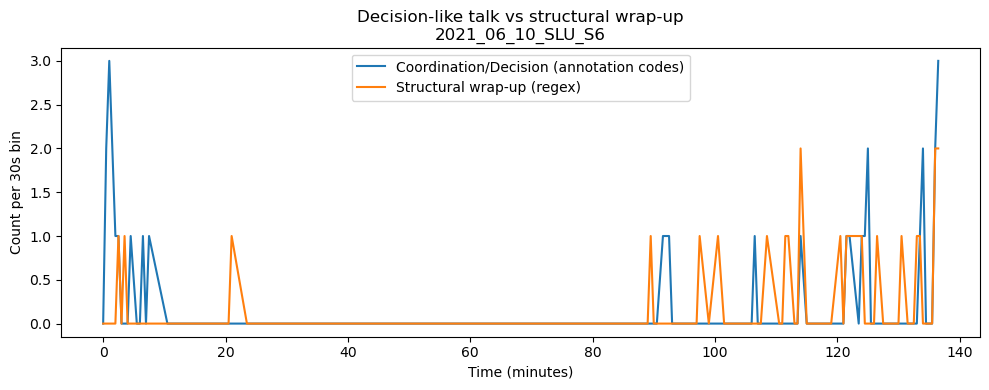

,t_min,start_time,end_time,is_commitment_code,is_logistics_text,text,codes
212,126.950000,66:57,67:39,False,True,"So the nice thing is the two are actually related. So energy is a fundamental component of the definition of Shannon information. It would be very hard to capture this in in in a slide but but these are two energy information and entropy are like these three really intrinsic characteristics and if you have unexpected structures on an inhabited world it would contain um more uh more information, more unexpected states.","[Knowledge Sharing, Idea Management]"
222,130.983333,70:59,71:41,False,True,"I guess there's another summary point. I don't know if any of us said the term, but from our discussion, we all seem to be kind of converging towards ideas of like agnostic biosignatures. You know, everything we're talking about here is really more of an agnostic biosignature than the these specific like oxygen or oxygen methane couples, you know, since I guess our question was so general, like general commonalities, you know, I think the only way to think about that and not get stuck in the just life as we know it realm is to think about these very general, you know, different types of information like Chris said or you know, just looking for general patterns and things that stick out.","[Integration Practices, Idea Management]"
228,133.116667,73:07,73:40,False,True,"Yeah, I think those kind of that kind of cycling on short time scales, I I completely agree. Um on very long time scales, there are things that evolution just can't adapt and respond to. And so those are the uh and those can be induced by biology itself. So those are the uh probably have the negative consequences for a longer term habitability.","[Idea Management, Knowledge Sharing, Relational Climate]"
229,133.683333,73:41,73:50,True,True,We have two minutes. Any other key points that encompass our conversation?,"[Coordination and Decision Practices, Integration Practices]"
231,134.200000,74:12,74:15,True,False,I saved the chat and I'll copy it into that document in a little bit.,[Coordination and Decision Practices]
233,134.300000,74:18,74:27,True,False,"Um so Joe, you think you're ready? Is there anything else you need any questions or comments for anybody else or is there anything else we forgot that anybody can think of?","[Information Seeking, Coordination and Decision Practices]"
241,136.316667,76:19,76:23,True,True,"Um just double checking Joe, you're ready? Do you need help with the slide?","[Information Seeking, Coordination and Decision Practices]"
242,136.400000,76:24,76:33,True,True,I think I should be okay. I just dumped a little bit of very tiny text on the slide. Uh can I put in just a new slide to answer our question or do you want it on the same?,"[Coordination and Decision Practices, Information Seeking]"


In [38]:
from pathlib import Path
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# 0) Pick ONE meeting (example)
# ----------------------------
SESSION_FP = Path(
    "/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/"
    "gemini_data_analysis/data/2021SLU/session_data/2021_06_10_SLU_S6.json"
)

# ----------------------------
# 1) Load JSON
# ----------------------------
with open(SESSION_FP, "r") as f:
    session = json.load(f)

# ----------------------------
# 2) Time helpers (robust + monotonic fix)
# ----------------------------
def time_str_to_sec(s: str) -> float:
    """Parse 'MM:SS' or 'HH:MM:SS' -> seconds."""
    if not isinstance(s, str) or ":" not in s:
        return np.nan
    parts = s.split(":")
    try:
        parts = [int(p) for p in parts]
    except ValueError:
        return np.nan
    if len(parts) == 2:
        mm, ss = parts
        return mm * 60 + ss
    if len(parts) == 3:
        hh, mm, ss = parts
        return hh * 3600 + mm * 60 + ss
    return np.nan

def unwrap_monotonic(sec_series: pd.Series, modulus: int = 3600, tol: float = 1.0) -> pd.Series:
    """
    Make times monotonic by adding `modulus` whenever the timer goes backwards.
    Handles mm:ss or hh:mm:ss counters that reset.
    """
    secs = pd.to_numeric(sec_series, errors="coerce").astype(float).to_numpy()
    out = np.full_like(secs, np.nan, dtype=float)

    offset = 0.0
    prev = None
    for i, s in enumerate(secs):
        if np.isnan(s):
            continue
        cur = s + offset
        if prev is not None and cur < prev - tol:
            offset += modulus
            cur = s + offset
        out[i] = cur
        prev = cur

    return pd.Series(out, index=sec_series.index)

# ----------------------------
# 3) Extract utterances robustly + APPLY unwrap
# ----------------------------
def extract_utterances(session_json: dict) -> pd.DataFrame:
    """
    Returns a dataframe with at least:
      - t_sec (float): monotonic start timestamp in seconds
      - dur_sec (float): duration in seconds (estimated if missing)
      - text (str)
      - codes (list[str])
      - start_time/end_time (original strings if present)
    """
    # Common candidates where utterances might live
    candidates = [
        session_json.get("all_data"),  # your SCIALOG schema
        session_json.get("utterances"),
        session_json.get("turns"),
        session_json.get("segments"),
        session_json.get("data", {}).get("utterances"),
        session_json.get("session", {}).get("utterances"),
    ]
    utt_list = next((c for c in candidates if isinstance(c, list)), None)
    if utt_list is None:
        raise ValueError("Couldn't find utterance list. Inspect session JSON keys and update extract_utterances().")

    rows = []
    for i, u in enumerate(utt_list):
        if not isinstance(u, dict):
            continue

        # Prefer explicit start/end time strings if present
        start_time = u.get("start_time") or u.get("start") or u.get("start_ts") or u.get("timestamp")
        end_time   = u.get("end_time")   or u.get("end")   or u.get("end_ts")

        # Numeric timestamps (fallback)
        t_num = (
            u.get("t_sec")
            or u.get("start_sec")
            or u.get("timestamp_sec")
            or u.get("time_sec")
            or u.get("start_time_sec")
        )

        # Parse seconds:
        # - if start_time looks like "MM:SS" use it
        # - else if numeric exists, use it
        start_sec_raw = time_str_to_sec(start_time) if isinstance(start_time, str) else np.nan
        if np.isnan(start_sec_raw):
            start_sec_raw = t_num if isinstance(t_num, (int, float, np.integer, np.floating)) else np.nan

        end_sec_raw = time_str_to_sec(end_time) if isinstance(end_time, str) else np.nan
        # If end is numeric in some schema
        if np.isnan(end_sec_raw):
            end_num = u.get("end_sec") or u.get("end_time_sec")
            if isinstance(end_num, (int, float, np.integer, np.floating)):
                end_sec_raw = end_num

        # Transcript fields (try a few)
        text = (
            u.get("text")
            or u.get("transcript")
            or u.get("utterance")
            or u.get("content")
            or ""
        )

        # Annotation codes fields (try a few)
        codes = (
            u.get("codes")
            or u.get("annotations")
            or u.get("annotation_codes")
            or u.get("labels")
            or []
        )

        # Normalize codes to list[str]
        if isinstance(codes, dict):
            codes = list(codes.keys())
        if isinstance(codes, str):
            codes = re.split(r"[;,|]\s*", codes.strip("[]() "))

        rows.append({
            "idx": i,
            "start_time": start_time,
            "end_time": end_time,
            "start_sec_raw": start_sec_raw,
            "end_sec_raw": end_sec_raw,
            "text": str(text),
            "codes": codes if isinstance(codes, list) else [],
        })

    df = pd.DataFrame(rows)

    df["text"] = df["text"].fillna("").astype(str)
    df["codes"] = df["codes"].apply(lambda x: x if isinstance(x, list) else [])

    df["start_sec_raw"] = pd.to_numeric(df["start_sec_raw"], errors="coerce")
    df["end_sec_raw"]   = pd.to_numeric(df["end_sec_raw"], errors="coerce")

    # Drop rows with no start time at all
    df = df.dropna(subset=["start_sec_raw"]).reset_index(drop=True)

    # --- THE FIX: unwrap timer resets ---
    df["start_sec"] = unwrap_monotonic(df["start_sec_raw"], modulus=3600, tol=1.0)
    df["end_sec"]   = unwrap_monotonic(df["end_sec_raw"],   modulus=3600, tol=1.0)

    # Fill missing end times using next start
    df["next_start_sec"] = df["start_sec"].shift(-1)
    df["end_sec"] = df["end_sec"].fillna(df["next_start_sec"])
    df["end_sec"] = df["end_sec"].fillna(df["start_sec"])

    # Duration (guard)
    df["dur_sec"] = (df["end_sec"] - df["start_sec"]).clip(lower=0)

    # Canonical time fields
    df["t_sec"] = df["start_sec"]
    df["t_min"] = df["t_sec"] / 60.0

    # Sort by monotonic time
    df = df.sort_values("t_sec").reset_index(drop=True)

    return df.drop(columns=["next_start_sec"])

df = extract_utterances(session)

# ----------------------------
# 4) Define the two signals for Slide 1:
#    A) "Decision-like / commitment" via codes
#    B) "Logistics/report-out" via lexical patterns
# ----------------------------
COMMITMENT_CODES = {
    "Coordination and Decision Practices",
    "Coordination/Decision Practices",
    "Coordination & Decision Practices",
    "Decision Practices",
    "Coordination Practices",
    "Commitment/Closure",
}

LOGISTICS_PAT = re.compile(
    r"\b("
    r"wrap up|time|times up|run out of time|next meeting|next steps|send|email|"
    r"slides?|deck|presentation|present|report out|report-out|main room|breakout|"
    r"zoom|screen share|screenshare|agenda|minutes|summar(y|ize)|"
    r"let's move on|we should stop|hard stop|have to go"
    r")\b",
    flags=re.IGNORECASE
)

def has_any_code(codes, target_set):
    return any(c in target_set for c in codes)

df["is_commitment_code"] = df["codes"].apply(lambda cs: has_any_code(cs, COMMITMENT_CODES))
df["is_logistics_text"]  = df["text"].apply(lambda t: bool(LOGISTICS_PAT.search(t)))

# ----------------------------
# 5) Bin over time and plot
# ----------------------------
BIN_SEC = 30
df["t_bin"] = (df["t_sec"] // BIN_SEC).astype(int) * BIN_SEC

bins = (
    df.groupby("t_bin")
      .agg(
          n_utt=("idx", "count"),
          n_commitment=("is_commitment_code", "sum"),
          n_logistics=("is_logistics_text", "sum"),
      )
      .reset_index()
)
bins["t_min"] = bins["t_bin"] / 60.0

plt.figure(figsize=(10, 4))
plt.plot(bins["t_min"], bins["n_commitment"], label="Coordination/Decision (annotation codes)")
plt.plot(bins["t_min"], bins["n_logistics"],  label="Structural wrap-up (regex)")
plt.xlabel("Time (minutes)")
plt.ylabel(f"Count per {BIN_SEC}s bin")
plt.title(f"Decision-like talk vs structural wrap-up\n{SESSION_FP.stem}")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# 6) Optional: pull example quotes near the end
# ----------------------------
end_threshold = df["t_sec"].quantile(0.85)  # last ~15% of meeting
end_df = df[df["t_sec"] >= end_threshold].copy()

examples = (
    end_df[end_df["is_commitment_code"] | end_df["is_logistics_text"]]
    .loc[:, ["t_min", "start_time", "end_time", "is_commitment_code", "is_logistics_text", "text", "codes"]]
    .head(8)
)

examples

#### taking one session first

sessions_df built: 34 sessions


,conference,session_id,session_fp,outcomes_fp
0,2020NES,2020_11_05_NES_S1,/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/gemini_data_analysis/data/2020NES/session_data/2020_11_05_NES_S1.json,None
1,2020NES,2020_11_05_NES_S2,/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/gemini_data_analysis/data/2020NES/session_data/2020_11_05_NES_S2.json,None
2,2020NES,2020_11_05_NES_S3,/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/gemini_data_analysis/data/2020NES/session_data/2020_11_05_NES_S3.json,None
3,2020NES,2020_11_05_NES_S4,/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/gemini_data_analysis/data/2020NES/session_data/2020_11_05_NES_S4.json,None
4,2020NES,2020_11_05_NES_S5,/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/gemini_data_analysis/data/2020NES/session_data/2020_11_05_NES_S5.json,None


Chosen meeting: 2020_11_05_NES_S3


,session_id,conference,session_fp,score,overlap_rate,decision_candidate_rate,convergence_phrase_rate,commitment_rate,logistics_rate,n_end_utterances
0,2020_11_05_NES_S3,2020NES,/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/gemini_data_analysis/data/2020NES/session_data/2020_11_05_NES_S3.json,1.766667,0.133333,0.466667,0.000000,0.600000,0.133333,15
24,2021_11_05_NES_S4,2021NES,/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/gemini_data_analysis/data/2021NES/session_data/2021_11_05_NES_S4.json,1.600000,0.133333,0.386667,0.000000,0.520000,0.200000,75
16,2021_11_04_NES_S1,2021NES,/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/gemini_data_analysis/data/2021NES/session_data/2021_11_04_NES_S1.json,1.461538,0.051282,0.487179,0.000000,0.538462,0.076923,39
33,2020_11_05_NES_S5,2020NES,/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/gemini_data_analysis/data/2020NES/session_data/2020_11_05_NES_S5.json,1.450000,0.100000,0.400000,0.000000,0.500000,0.100000,10
21,2020_11_06_NES_S2,2020NES,/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/gemini_data_analysis/data/2020NES/session_data/2020_11_06_NES_S2.json,1.403846,0.153846,0.269231,0.038462,0.423077,0.230769,26
20,2021_11_05_NES_S11,2021NES,/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/gemini_data_analysis/data/2021NES/session_data/2021_11_05_NES_S11.json,1.390000,0.120000,0.320000,0.000000,0.440000,0.220000,50
22,2021_11_05_NES_S2,2021NES,/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/gemini_data_analysis/data/2021NES/session_data/2021_11_05_NES_S2.json,1.300000,0.090909,0.345455,0.000000,0.436364,0.145455,55
31,2021_11_05_NES_S1,2021NES,/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/gemini_data_analysis/data/2021NES/session_data/2021_11_05_NES_S1.json,1.140625,0.078125,0.304688,0.015625,0.382812,0.132812,128
14,2021_11_05_NES_S5,2021NES,/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/gemini_data_analysis/data/2021NES/session_data/2021_11_05_NES_S5.json,0.970000,0.060000,0.260000,0.000000,0.320000,0.160000,100
10,2021_11_05_NES_S7,2021NES,/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/gemini_data_analysis/data/2021NES/session_data/2021_11_05_NES_S7.json,0.961207,0.060345,0.275862,0.000000,0.336207,0.060345,116


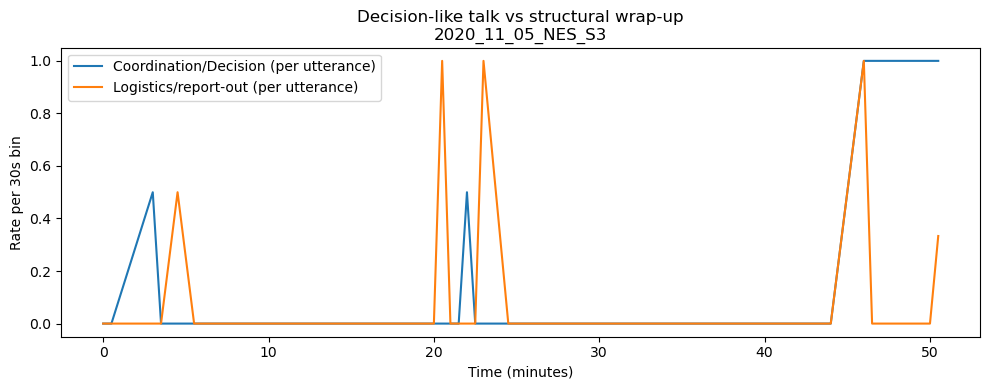


=== Structural closure (commitment + logistics) ===


,t_min,start_time,end_time,is_commitment_code,is_logistics_text,is_convergence_phrase,text,codes
36,46.433333,46:26,46:48,True,True,False,"Great. So I'd like to we're we're actually at about eight minutes from close here. So I'd like to try to give Xiao some help with reporting and make sure that the right messages get back. Xiao, do you want to share your your screen and we can all look at the slide and","[Coordination and Decision Practices, Participation Dynamics]"
44,50.983333,50:59,51:35,True,True,False,Okay. So let's see. I mean I think my suggestion is that you know we can choose maybe one more and you would spend more time talking a little talking about those and if you had time you could mention the others but does anybody have a third topic that that we should take to the report out?,"[Coordination and Decision Practices, Information Seeking, Participation Dynamics]"



=== Decision candidates (commitment, NOT logistics) ===


,t_min,start_time,end_time,is_commitment_code,is_logistics_text,is_convergence_phrase,text,codes
37,46.800000,46:48,47:14,True,False,False,Yeah sure. I yeah sure. So I've been furiously typing because you guys have been getting a lot of very quick ideas. So I have like a very long word file here that I was just typing but I while you guys were just discussing here I put everything on the PowerPoint. So maybe we can take a look at the PowerPoint and you guys can give me feedback. It's a little bit long. So I don't know if there were I don't know Jeff if there were guidelines for how long we could put it in.,"[Coordination and Decision Practices, Information Seeking, Knowledge Sharing]"
38,47.233333,47:14,47:28,True,False,False,Oh. Well so they they asked for just a few of the topics or points or ideas that we discussed that we all agreed were most most interesting to share.,"[Knowledge Sharing, Coordination and Decision Practices]"
39,47.466667,47:28,48:51,True,False,False,"Okay. I think we'd like to pick a few for you to Okay, one second. Let me put it on this one here because I have a bigger screen. Yeah, so thank you for doing this. It's not I know it's very hard work. Oh no no no not at all. I'd rather listen and write it down than Yeah. So I basically can you guys see the screen with the PowerPoint? Okay cool. So I just basically went by because there's a couple of repeat topics so I I sort of grouped them into major categories here. So first I think we started off with degradation pathways and there was a that's sort of what set off the discussion about and then so I just put down those points there. Reactor format. I think we discussed a lot about what sort of engineering systems we do that. I don't know if we we had like somebody made a good comment about oh electrochemical sorbents the best solution. I thought that was a cool sort of introverted like insightful question on our own platform but I don't know if you want to keep that. I think that somebody said it was a good opportunity to develop multifunctional materials, maybe use a backbone actually no it was an IL backbone with a redox active material.","[Integration Practices, Coordination and Decision Practices, Relational Climate]"
40,50.000000,50:00,50:24,True,False,False,try to narrow the focus for a few of the things that people think are most compelling to to share with the broader group. So does anybody have a topic or theme here that they'd they really feel was was is worth taking to everyone?,"[Coordination and Decision Practices, Participation Dynamics]"
41,50.400000,50:24,50:33,True,False,False,"I think that discussion on improving the quinone chemistries or alternatives to quinone chemistries, I think that was very productive.","[Idea Management, Evaluation Practices, Coordination and Decision Practices]"
42,50.566667,50:34,50:48,True,False,False,Yeah. I that did seem so in the beginning that that seemed like there were a lot of people who might connect on that. Do others agree?,"[Evaluation Practices, Participation Dynamics, Coordination and Decision Practices]"



=== Convergence phrase candidates (phrase, NOT logistics) ===


,t_min,start_time,end_time,is_commitment_code,is_logistics_text,is_convergence_phrase,text,codes


In [39]:
from pathlib import Path
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# ONE-DONE: Build sessions_df + auto-pick best Slide-1 example
# ============================================================

# ----------------------------
# 0) CONFIG: where your session JSONs live
# ----------------------------
# Point this at folders that contain *.json session files (SCIALOG/NES session_data).
# Add as many roots as you want.
DATA_ROOTS = [
    Path("/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/gemini_data_analysis/data")
]

# Patterns for conference folder names you care about (optional)
CONFERENCE_ALLOWLIST = {"2020NES", "2021NES"}  # set to None to allow all

# ----------------------------
# 1) Build sessions_df (no more NameError)
# ----------------------------
def build_sessions_df(data_roots, conference_allowlist=None) -> pd.DataFrame:
    rows = []

    for root in data_roots:
        if not root.exists():
            continue

        # Expect structure like: root/<conference>/session_data/*.json
        for conf_dir in root.glob("*"):
            if not conf_dir.is_dir():
                continue

            conf_name = conf_dir.name
            if conference_allowlist is not None and conf_name not in conference_allowlist:
                continue

            session_dir = conf_dir / "session_data"
            if not session_dir.exists():
                # fallback: maybe jsons directly inside conf_dir
                session_dir = conf_dir

            for fp in session_dir.glob("*.json"):
                session_id = fp.stem  # e.g., 2021_11_04_NES_S6
                rows.append({
                    "conference": conf_name,
                    "session_id": session_id,
                    "session_fp": str(fp),
                    "outcomes_fp": None,  # not needed for this chunk
                })

    df = pd.DataFrame(rows)
    if len(df) == 0:
        raise RuntimeError(
            "No session JSON files found. Check DATA_ROOTS and folder structure.\n"
            "Expected something like .../data/<conference>/session_data/*.json"
        )
    return df.sort_values(["conference", "session_id"]).reset_index(drop=True)

sessions_df = build_sessions_df(DATA_ROOTS, conference_allowlist=CONFERENCE_ALLOWLIST)
print("sessions_df built:", len(sessions_df), "sessions")
display(sessions_df.head(5))

# ----------------------------
# 2) Helpers
# ----------------------------
def time_str_to_sec(s: str) -> float:
    if not isinstance(s, str) or ":" not in s:
        return np.nan
    parts = s.split(":")
    try:
        parts = [int(p) for p in parts]
    except ValueError:
        return np.nan
    if len(parts) == 2:
        mm, ss = parts
        return mm * 60 + ss
    if len(parts) == 3:
        hh, mm, ss = parts
        return hh * 3600 + mm * 60 + ss
    return np.nan

def extract_utterances_scialog(session_json: dict) -> pd.DataFrame:
    if "all_data" not in session_json or not isinstance(session_json["all_data"], list):
        raise ValueError("Expected session_json['all_data'] to be a list.")

    rows = []
    for i, u in enumerate(session_json["all_data"]):
        if not isinstance(u, dict):
            continue

        start_time = u.get("start_time")
        end_time   = u.get("end_time")
        t_sec = time_str_to_sec(start_time)

        text = u.get("transcript", "") or ""
        ann = u.get("annotations", {})
        codes = list(ann.keys()) if isinstance(ann, dict) else []

        rows.append({
            "idx": i,
            "t_sec": t_sec,
            "start_time": start_time,
            "end_time": end_time,
            "text": str(text),
            "codes": codes,
        })

    df = pd.DataFrame(rows)
    df["t_sec"] = pd.to_numeric(df["t_sec"], errors="coerce")
    df = df.dropna(subset=["t_sec"]).sort_values("t_sec").reset_index(drop=True)
    df["t_min"] = df["t_sec"] / 60.0
    return df

def has_any_code(codes, target_set):
    return any(c in target_set for c in codes)

# ----------------------------
# 3) Signals
# ----------------------------
COMMITMENT_CODES = {"Coordination and Decision Practices"}

LOGISTICS_PAT = re.compile(
    r"\b("
    r"wrap up|time|times up|run out of time|hard stop|"
    r"next meeting|next steps|follow up|send|email|"
    r"slides?|deck|presentation|present|report out|report-out|"
    r"agenda|minutes|summar(y|ize)|"
    r"let's move on|we should stop|have to go|"
    r"screen sharing|screenshare|slide number"
    r")\b",
    flags=re.IGNORECASE
)

CONVERGENCE_PAT = re.compile(
    r"\b("
    r"we (all )?agree|consensus|settle on|go with|we'll go with|"
    r"we decide|we decided|final decision|the plan is|"
    r"we will do|we're going to do"
    r")\b",
    flags=re.IGNORECASE
)

# ----------------------------
# 4) Score meetings to pick best Slide-1 example
# ----------------------------
def score_meeting(session_fp: Path, end_q=2/3) -> dict:
    with open(session_fp, "r") as f:
        session = json.load(f)
    df = extract_utterances_scialog(session)

    df["is_commitment_code"]   = df["codes"].apply(lambda cs: has_any_code(cs, COMMITMENT_CODES))
    df["is_logistics_text"]    = df["text"].apply(lambda t: bool(LOGISTICS_PAT.search(t)))
    df["is_convergence_phrase"]= df["text"].apply(lambda t: bool(CONVERGENCE_PAT.search(t)))

    end_threshold = df["t_sec"].quantile(end_q)
    end_df = df[df["t_sec"] >= end_threshold].copy()

    n = len(end_df)
    if n == 0:
        return {"ok": False}

    commitment_rate = end_df["is_commitment_code"].mean()
    logistics_rate  = end_df["is_logistics_text"].mean()
    overlap_rate    = (end_df["is_commitment_code"] & end_df["is_logistics_text"]).mean()
    decision_candidate_rate = (end_df["is_commitment_code"] & (~end_df["is_logistics_text"])).mean()
    convergence_phrase_rate = (end_df["is_convergence_phrase"] & (~end_df["is_logistics_text"])).mean()

    # Slide-1 wants: lots of "decision-ish" talk entangled with logistics/closeout
    score = (
        2.5 * overlap_rate +
        1.5 * commitment_rate +
        1.0 * decision_candidate_rate +
        0.5 * logistics_rate
    )

    return {
        "ok": True,
        "score": float(score),
        "commitment_rate": float(commitment_rate),
        "logistics_rate": float(logistics_rate),
        "overlap_rate": float(overlap_rate),
        "decision_candidate_rate": float(decision_candidate_rate),
        "convergence_phrase_rate": float(convergence_phrase_rate),
        "n_end_utterances": int(n),
        "df": df,
        "end_df": end_df,
    }

def pick_best_meeting(sessions_df: pd.DataFrame, max_checks=60, seed=7) -> tuple[Path, dict, pd.DataFrame]:
    # Shuffle so you don't just pick "first 60" every time
    candidates = sessions_df.sample(n=min(max_checks, len(sessions_df)), random_state=seed).copy()

    scored_rows = []
    best = None

    for _, r in candidates.iterrows():
        fp = Path(r["session_fp"])
        try:
            out = score_meeting(fp)
        except Exception:
            continue
        if not out.get("ok"):
            continue

        scored_rows.append({
            "session_id": r["session_id"],
            "conference": r["conference"],
            "session_fp": str(fp),
            "score": out["score"],
            "overlap_rate": out["overlap_rate"],
            "decision_candidate_rate": out["decision_candidate_rate"],
            "convergence_phrase_rate": out["convergence_phrase_rate"],
            "commitment_rate": out["commitment_rate"],
            "logistics_rate": out["logistics_rate"],
            "n_end_utterances": out["n_end_utterances"],
        })

        if best is None or out["score"] > best[1]["score"]:
            best = (fp, out)

    scored_df = pd.DataFrame(scored_rows).sort_values("score", ascending=False)
    if best is None:
        raise RuntimeError("No valid meetings scored. Try increasing max_checks or inspect JSON schema.")
    return best[0], best[1], scored_df

# ----------------------------
# 5) Pick meeting (auto) + plot + examples
# ----------------------------
SESSION_FP, scored, scored_df = pick_best_meeting(sessions_df, max_checks=80)

df = scored["df"].copy()
print("Chosen meeting:", SESSION_FP.stem)
display(scored_df.head(10))

# Bin + plot
BIN_SEC = 30
df["t_bin"] = (df["t_sec"] // BIN_SEC).astype(int) * BIN_SEC
bins = (
    df.groupby("t_bin")
      .agg(
          n_utt=("idx", "count"),
          n_commitment=("is_commitment_code", "sum"),
          n_logistics=("is_logistics_text", "sum"),
      )
      .reset_index()
)
bins["t_min"] = bins["t_bin"] / 60.0
bins["commitment_per_utt"] = bins["n_commitment"] / bins["n_utt"].replace(0, np.nan)
bins["logistics_per_utt"]  = bins["n_logistics"]  / bins["n_utt"].replace(0, np.nan)

plt.figure(figsize=(10, 4))
plt.plot(bins["t_min"], bins["commitment_per_utt"], label="Coordination/Decision (per utterance)")
plt.plot(bins["t_min"], bins["logistics_per_utt"],  label="Logistics/report-out (per utterance)")
plt.xlabel("Time (minutes)")
plt.ylabel(f"Rate per {BIN_SEC}s bin")
plt.title(f"Decision-like talk vs structural wrap-up\n{SESSION_FP.stem}")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# 6) Slide callouts from last third
# ----------------------------
end_df = scored["end_df"].copy()
end_df["is_commitment_code"]    = end_df["codes"].apply(lambda cs: has_any_code(cs, COMMITMENT_CODES))
end_df["is_logistics_text"]     = end_df["text"].apply(lambda t: bool(LOGISTICS_PAT.search(t)))
end_df["is_convergence_phrase"] = end_df["text"].apply(lambda t: bool(CONVERGENCE_PAT.search(t)))

COLS = ["t_min", "start_time", "end_time",
        "is_commitment_code", "is_logistics_text", "is_convergence_phrase",
        "text", "codes"]

structural = end_df[end_df["is_commitment_code"] & end_df["is_logistics_text"]].copy()
decision_candidate = end_df[end_df["is_commitment_code"] & (~end_df["is_logistics_text"])].copy()
genuine_candidate = end_df[end_df["is_convergence_phrase"] & (~end_df["is_logistics_text"])].copy()

print("\n=== Structural closure (commitment + logistics) ===")
display(structural.loc[:, COLS].head(6))

print("\n=== Decision candidates (commitment, NOT logistics) ===")
display(decision_candidate.loc[:, COLS].head(6))

print("\n=== Convergence phrase candidates (phrase, NOT logistics) ===")
display(genuine_candidate.loc[:, COLS].head(6))

### Chosen meeting: 2020_11_05_NES_S3

,third,n_utt,commitment_count,structural_count,commitment_time_sec,structural_time_sec,commitment_time_min,structural_time_min
0,beginning,11,1,1,9.0,57.0,0.150000,0.950000
1,middle,19,1,2,40.0,88.0,0.666667,1.466667
2,end,15,9,2,239.0,58.0,3.983333,0.966667


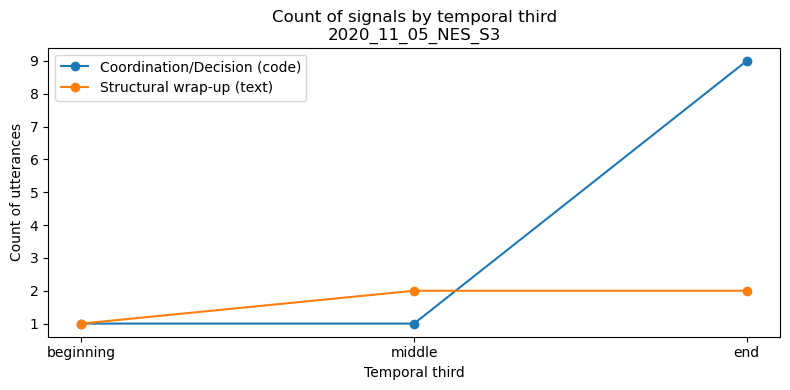

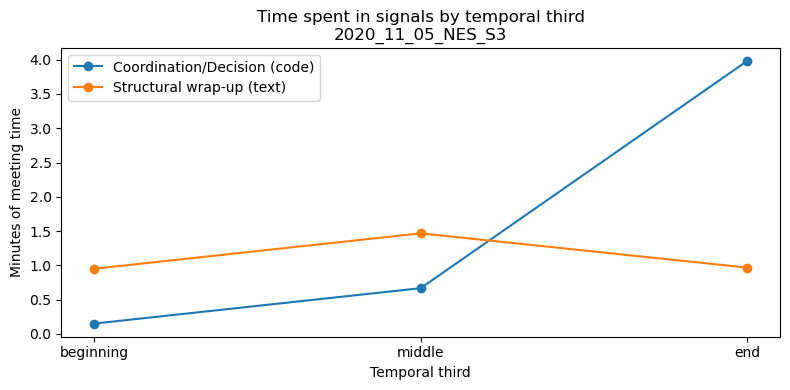

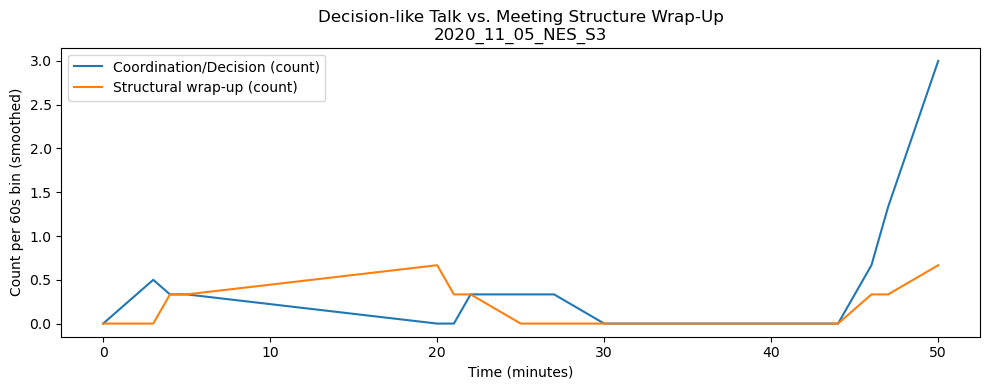

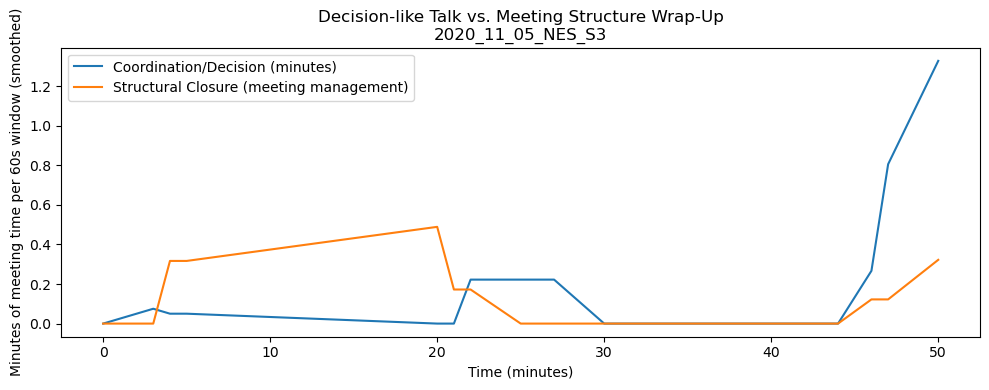

,t_min,start_time,end_time,text,codes
36,46.433333,46:26,46:48,"Great. So I'd like to we're we're actually at about eight minutes from close here. So I'd like to try to give Xiao some help with reporting and make sure that the right messages get back. Xiao, do you want to share your your screen and we can all look at the slide and","[Coordination and Decision Practices, Participation Dynamics]"



--- FULL QUOTE WINDOW (±2 utterances) ---
[44:02–44:26] I have a question for related to what you were saying about scale. And I know some of you guys work with flow batteries too, which is probably related. Is there an optimal scale at which to run these electrochemical processes and is it can you can you scale it down without any loss indefinitely? Like what's what's what what sizes matter?
[44:26–46:26] It depends on the process a little bit and it depends upon where your cost is in the process. So for example, you could sort of think of it as flow batteries are an easy example because you can separate power and energy and so if you want an energy intensive application, the cost is dominated by what's in your tank. If you have a power dominant application it's dominated by what it costs you to make the reactor. In these kind of systems it's a bit different, right? And it would probably the way you'd want to think about it is throughput, right? So it's kind of what is the capital co

In [40]:
from pathlib import Path
import json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Display settings (no truncation)
# ----------------------------
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 200)

# ----------------------------
# 0) Pick ONE meeting (example)
# ----------------------------
SESSION_FP = Path(
    "/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/"
    "gemini_data_analysis/data/2020NES/session_data/2020_11_05_NES_S3.json"
)

# ----------------------------
# 1) Load JSON
# ----------------------------
with open(SESSION_FP, "r") as f:
    session = json.load(f)

# ----------------------------
# 2) Helpers
# ----------------------------
def time_str_to_sec(s: str) -> float:
    if not isinstance(s, str) or ":" not in s:
        return np.nan
    parts = s.split(":")
    try:
        parts = [int(p) for p in parts]
    except ValueError:
        return np.nan
    if len(parts) == 2:
        mm, ss = parts
        return mm * 60 + ss
    if len(parts) == 3:
        hh, mm, ss = parts
        return hh * 3600 + mm * 60 + ss
    return np.nan

def extract_utterances_scialog(session_json: dict) -> pd.DataFrame:
    if "all_data" not in session_json or not isinstance(session_json["all_data"], list):
        raise ValueError("Expected session_json['all_data'] to be a list.")

    rows = []
    for i, u in enumerate(session_json["all_data"]):
        start_time = u.get("start_time")
        end_time   = u.get("end_time")

        start_sec = time_str_to_sec(start_time)
        end_sec   = time_str_to_sec(end_time)

        text = (u.get("transcript", "") or "").strip()
        ann = u.get("annotations", {})
        codes = list(ann.keys()) if isinstance(ann, dict) else []

        rows.append({
            "idx": i,
            "start_time": start_time,
            "end_time": end_time,
            "start_sec": start_sec,
            "end_sec": end_sec,
            "text": text,
            "codes": codes,
        })

    df = pd.DataFrame(rows)
    df = df.dropna(subset=["start_sec"]).sort_values("start_sec").reset_index(drop=True)

    # If end_sec is missing, approximate using next start_sec; last row fallback to start_sec
    df["next_start_sec"] = df["start_sec"].shift(-1)
    df["end_sec"] = df["end_sec"].fillna(df["next_start_sec"])
    df["end_sec"] = df["end_sec"].fillna(df["start_sec"])

    # Duration (guard against negatives)
    df["dur_sec"] = (df["end_sec"] - df["start_sec"]).clip(lower=0)

    df["t_sec"] = df["start_sec"]
    df["t_min"] = df["t_sec"] / 60.0

    return df.drop(columns=["next_start_sec"])

def has_any_code(codes, target_set):
    return any(c in target_set for c in codes)

# ----------------------------
# 3) Extract utterances
# ----------------------------
df = extract_utterances_scialog(session)

# ----------------------------
# 4) Signal definitions
# ----------------------------
COMMITMENT_CODES = {"Coordination and Decision Practices"}

STRUCTURAL_WRAP_PAT = re.compile(
    r"\b("
    r"wrap up|time|times up|run out of time|hard stop|"
    r"next meeting|next steps|follow up|send|email|"
    r"slides?|deck|presentation|present|report out|report-out|"
    r"agenda|minutes|summar(y|ize)|"
    r"let's move on|we should stop|have to go|"
    r"screen sharing|screenshare|slide number"
    r")\b",
    flags=re.IGNORECASE
)

CONVERGENCE_PAT = re.compile(
    r"\b("
    r"we (all )?agree|consensus|settle on|go with|we'll go with|"
    r"we decide|we decided|final decision|the plan is|"
    r"we will do|we're going to do"
    r")\b",
    flags=re.IGNORECASE
)

df["is_commitment_code"]      = df["codes"].apply(lambda cs: has_any_code(cs, COMMITMENT_CODES))
df["is_structural_wrap_text"] = df["text"].apply(lambda t: bool(STRUCTURAL_WRAP_PAT.search(t)))
df["is_convergence_phrase"]   = df["text"].apply(lambda t: bool(CONVERGENCE_PAT.search(t)))

# ----------------------------
# 5) Assign temporal thirds (beginning / middle / end)
# ----------------------------
meeting_start = float(df["start_sec"].min())
meeting_end   = float(df["end_sec"].max())
meeting_len   = max(1.0, meeting_end - meeting_start)

t1 = meeting_start + meeting_len / 3.0
t2 = meeting_start + 2.0 * meeting_len / 3.0

def temporal_third(t_sec: float) -> str:
    if t_sec < t1:
        return "beginning"
    if t_sec < t2:
        return "middle"
    return "end"

df["third"] = df["t_sec"].apply(temporal_third)

# ----------------------------
# 6) Temporal-third summaries (COUNT + MINUTES)
# ----------------------------
third_order = ["beginning", "middle", "end"]

third_summary = (
    df.groupby("third")
      .agg(
          n_utt=("idx", "count"),
          commitment_count=("is_commitment_code", "sum"),
          structural_count=("is_structural_wrap_text", "sum"),
          commitment_time_sec=("dur_sec", lambda s: float(s[df.loc[s.index, "is_commitment_code"]].sum())),
          structural_time_sec=("dur_sec", lambda s: float(s[df.loc[s.index, "is_structural_wrap_text"]].sum())),
      )
      .reindex(third_order)
      .reset_index()
)

third_summary["commitment_time_min"] = third_summary["commitment_time_sec"] / 60.0
third_summary["structural_time_min"] = third_summary["structural_time_sec"] / 60.0

display(third_summary)

# ---- Graph A (thirds): COUNT ----
plt.figure(figsize=(8,4))
plt.plot(third_summary["third"], third_summary["commitment_count"], marker="o", label="Coordination/Decision (code)")
plt.plot(third_summary["third"], third_summary["structural_count"], marker="o", label="Structural wrap-up (text)")
plt.xlabel("Temporal third")
plt.ylabel("Count of utterances")
plt.title(f"Count of signals by temporal third\n{SESSION_FP.stem}")
plt.legend()
plt.tight_layout()
plt.show()

# ---- Graph B (thirds): TIME ----
plt.figure(figsize=(8,4))
plt.plot(third_summary["third"], third_summary["commitment_time_min"], marker="o", label="Coordination/Decision (code)")
plt.plot(third_summary["third"], third_summary["structural_time_min"], marker="o", label="Structural wrap-up (text)")
plt.xlabel("Temporal third")
plt.ylabel("Minutes of meeting time")
plt.title(f"Time spent in signals by temporal third\n{SESSION_FP.stem}")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# 7) Time-series by bin: (A) COUNT per bin, (B) MINUTES per bin
# ----------------------------
BIN_SEC = 60
MIN_UTT_PER_BIN = 2
SMOOTH_WINDOW_BINS = 3

df["t_bin"] = (df["t_sec"] // BIN_SEC).astype(int) * BIN_SEC

def sum_if(mask_col: str):
    # sums dur_sec within group where that mask is True
    def _inner(s):
        idxs = s.index
        mask = df.loc[idxs, mask_col]
        return float(s[mask].sum())
    return _inner

bins = (
    df.groupby("t_bin")
      .agg(
          n_utt=("idx", "count"),

          # COUNT of utterances in bin with signal
          commitment_count=("is_commitment_code", "sum"),
          structural_count=("is_structural_wrap_text", "sum"),

          # TIME (sec) spent in utterances with signal
          commitment_time_sec=("dur_sec", sum_if("is_commitment_code")),
          structural_time_sec=("dur_sec", sum_if("is_structural_wrap_text")),
      )
      .reset_index()
)

bins["t_min"] = bins["t_bin"] / 60.0
bins = bins[bins["n_utt"] >= MIN_UTT_PER_BIN].copy()

# Convert to minutes for plot readability
bins["commitment_time_min"] = bins["commitment_time_sec"] / 60.0
bins["structural_time_min"] = bins["structural_time_sec"] / 60.0

# Smooth (optional but consistent with your previous plots)
for col in ["commitment_count", "structural_count", "commitment_time_min", "structural_time_min"]:
    bins[f"{col}_smooth"] = bins[col].rolling(SMOOTH_WINDOW_BINS, min_periods=1).mean()

# ---- Graph C (time series): COUNT per bin ----
plt.figure(figsize=(10,4))
plt.plot(bins["t_min"], bins["commitment_count_smooth"], label="Coordination/Decision (count)")
plt.plot(bins["t_min"], bins["structural_count_smooth"], label="Structural wrap-up (count)")
plt.xlabel("Time (minutes)")
plt.ylabel(f"Count per {BIN_SEC}s bin (smoothed)")
plt.title(f"Decision-like Talk vs. Meeting Structure Wrap-Up\n{SESSION_FP.stem}")
plt.legend()
plt.tight_layout()
plt.show()

# ---- Graph D (time series): MINUTES per bin ----
plt.figure(figsize=(10,4))
plt.plot(bins["t_min"], bins["commitment_time_min_smooth"], label="Coordination/Decision (minutes)")
plt.plot(bins["t_min"], bins["structural_time_min_smooth"], label="Structural Closure (meeting management)")
plt.xlabel("Time (minutes)")
plt.ylabel(f"Minutes of meeting time per 60s window (smoothed)")
plt.title(f"Decision-like Talk vs. Meeting Structure Wrap-Up\n{SESSION_FP.stem}")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# 8) End-of-meeting candidates + quotes (last third)
# ----------------------------
end_df = df[df["t_sec"] >= t2].copy()

structural = end_df[end_df["is_commitment_code"] & end_df["is_structural_wrap_text"]].copy()
decision_candidate = end_df[end_df["is_commitment_code"] & ~end_df["is_structural_wrap_text"]].copy()

ACTIONY = re.compile(r"\b(narrow|pick|plan|decision|go with|final)\b", re.I)

def slide_score(text):
    if not isinstance(text, str):
        return 0.0
    return min(len(text), 250) / 250 + (1 if ACTIONY.search(text) else 0)

for d in (structural, decision_candidate):
    d["slide_score"] = d["text"].apply(slide_score)

def quote_window(df, center_idx, n_before=2, n_after=2):
    lo = max(0, center_idx - n_before)
    hi = min(len(df)-1, center_idx + n_after)
    chunk = df.loc[lo:hi, ["start_time","end_time","text"]].copy()
    chunk["text"] = chunk["text"].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
    return "\n".join(
        f"[{r.start_time}–{r.end_time}] {r.text}"
        for r in chunk.itertuples(index=False)
    )

best_structural = structural.sort_values("slide_score", ascending=False).head(1)
display(best_structural[["t_min","start_time","end_time","text","codes"]])

best_idx = int(best_structural.index[0])

print("\n--- FULL QUOTE WINDOW (±2 utterances) ---")
print(quote_window(df, best_idx, 2, 2))

best_text = df.loc[best_idx, "text"]
best_stamp = f'{df.loc[best_idx,"start_time"]}–{df.loc[best_idx,"end_time"]}'
print(f'\nSLIDE CALLOUT:\n({best_stamp}) “{best_text}”')

### Slide 10 - Part 2

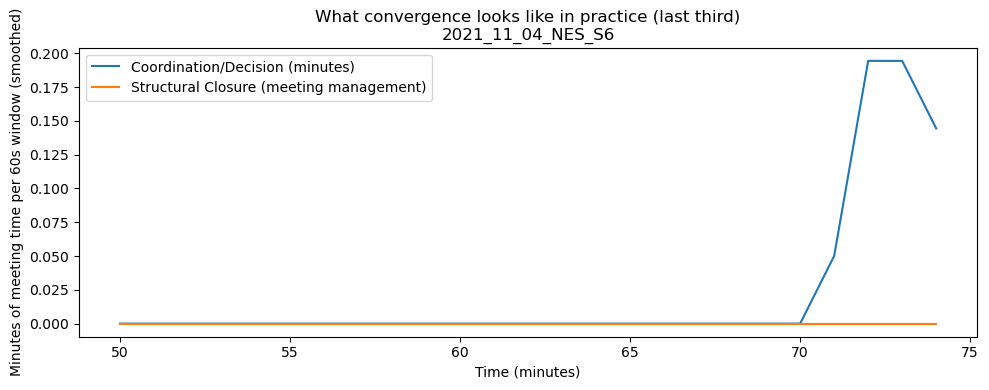


SLIDE CALLOUT (strict convergence):
(72:42–73:08) “Okay, yeah, I agree with you, Will. Uh, I think we need to, uh, to be more specific about what we're going to do. Uh, I think we need to, uh, to have a clear plan for how we're going to achieve the goals. Uh, I think we need to, uh, to have a clear plan for how we're going to achieve the goals. Uh, I think we need to, uh, to have a clear plan for how we're going to achieve the goals.”


In [41]:
from pathlib import Path
import json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# SLIDE 2 (Convergence example) – matched to Slide 1 styling
# ============================================================

# ----------------------------
# CONFIG (match Slide 1)
# ----------------------------
BIN_SEC = 60
SMOOTH_WINDOW_BINS = 3
PLOT_LAST_THIRD_ONLY = True   # True = last third only (recommended for Slide 2)

# Callout controls
PRINT_FULL_CALLOUT_TEXT = True     # True = print the entire utterance text (no truncation)
ALSO_PRINT_CONTEXT = False         # True = print nearby utterances for context
CONTEXT_UTTERANCES_BEFORE = 2
CONTEXT_UTTERANCES_AFTER  = 2

SESSION_FP2 = Path(
    "/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/"
    "gemini_data_analysis/data/2021NES/session_data/2021_11_04_NES_S6.json"
)

# ----------------------------
# Helpers
# ----------------------------
def time_str_to_sec(s: str) -> float:
    if not isinstance(s, str) or ":" not in s:
        return np.nan
    parts = s.split(":")
    try:
        parts = [int(p) for p in parts]
    except ValueError:
        return np.nan
    if len(parts) == 2:
        mm, ss = parts
        return mm * 60 + ss
    if len(parts) == 3:
        hh, mm, ss = parts
        return hh * 3600 + mm * 60 + ss
    return np.nan

def extract_utterances_scialog(session_json: dict) -> pd.DataFrame:
    rows = []
    for i, u in enumerate(session_json.get("all_data", [])):
        if not isinstance(u, dict):
            continue

        start_time = u.get("start_time")
        end_time   = u.get("end_time")
        start_sec  = time_str_to_sec(start_time)
        end_sec    = time_str_to_sec(end_time)

        text = (u.get("transcript", "") or "").strip()
        ann = u.get("annotations", {})
        codes = list(ann.keys()) if isinstance(ann, dict) else []

        rows.append({
            "idx": i,
            "start_time": start_time,
            "end_time": end_time,
            "start_sec": start_sec,
            "end_sec": end_sec,
            "text": text,
            "codes": codes,
        })

    df = pd.DataFrame(rows)
    df["start_sec"] = pd.to_numeric(df["start_sec"], errors="coerce")
    df["end_sec"]   = pd.to_numeric(df["end_sec"], errors="coerce")
    df = df.dropna(subset=["start_sec"]).sort_values("start_sec").reset_index(drop=True)

    # If end_sec is missing, approximate with next start_sec; last row fallback to start_sec
    df["next_start_sec"] = df["start_sec"].shift(-1)
    df["end_sec"] = df["end_sec"].fillna(df["next_start_sec"])
    df["end_sec"] = df["end_sec"].fillna(df["start_sec"])

    df["dur_sec"] = (df["end_sec"] - df["start_sec"]).clip(lower=0)
    df["t_sec"] = df["start_sec"]
    df["t_min"] = df["t_sec"] / 60.0

    return df.drop(columns=["next_start_sec"])

def has_any_code(codes, target_set):
    return any(c in target_set for c in codes)

def clean_text(s: str) -> str:
    return re.sub(r"\s+", " ", str(s)).strip()

# ----------------------------
# Signals
# ----------------------------
COMMITMENT_CODES = {"Coordination and Decision Practices"}

STRUCTURAL_WRAP_PAT = re.compile(
    r"\b("
    r"wrap up|time|times up|run out of time|hard stop|"
    r"next meeting|next steps|follow up|send|email|"
    r"slides?|deck|presentation|present|report out|report-out|"
    r"agenda|minutes|summar(y|ize)|"
    r"let's move on|we should stop|have to go|"
    r"screen sharing|screenshare|slide number"
    r")\b",
    flags=re.IGNORECASE
)

# Strict convergence phrase detector (expand later as needed)
CONVERGENCE_PAT = re.compile(
    r"\b("
    r"we (all )?agree|consensus|settle on|go with|we'll go with|"
    r"we decide|we decided|final decision|the plan is|"
    r"we will do|we're going to do"
    r")\b",
    flags=re.IGNORECASE
)

# ----------------------------
# Load + build df
# ----------------------------
with open(SESSION_FP2, "r") as f:
    session2 = json.load(f)

df2 = extract_utterances_scialog(session2)

df2["is_commitment_code"] = df2["codes"].apply(lambda cs: has_any_code(cs, COMMITMENT_CODES))
df2["is_structural_wrap_text"] = df2["text"].apply(lambda t: bool(STRUCTURAL_WRAP_PAT.search(t)))
df2["is_convergence_phrase"] = df2["text"].apply(lambda t: bool(CONVERGENCE_PAT.search(t)))

# Strict convergence = (agreement/settle language) + (commitment code) - (structural wrap)
df2["is_strict_convergence"] = (
    df2["is_convergence_phrase"] &
    df2["is_commitment_code"] &
    (~df2["is_structural_wrap_text"])
)

# ----------------------------
# Optional: restrict to last third of meeting
# ----------------------------
meeting_start = float(df2["start_sec"].min())
meeting_end   = float(df2["end_sec"].max())
meeting_len   = max(1.0, meeting_end - meeting_start)
last_third_start = meeting_start + 2.0 * meeting_len / 3.0

plot_df = df2[df2["t_sec"] >= last_third_start].copy() if PLOT_LAST_THIRD_ONLY else df2.copy()

# ----------------------------
# Bin to: minutes of meeting time per 60s window
# ----------------------------
plot_df["t_bin"] = (plot_df["t_sec"] // BIN_SEC).astype(int) * BIN_SEC

bin_summary = (
    plot_df.groupby("t_bin")
      .agg(
          strict_conv_time_sec=("dur_sec", lambda s: float(s[plot_df.loc[s.index, "is_strict_convergence"]].sum())),
          structural_time_sec=("dur_sec", lambda s: float(s[plot_df.loc[s.index, "is_structural_wrap_text"]].sum())),
      )
      .reset_index()
)

bin_summary["t_min"] = bin_summary["t_bin"] / 60.0
bin_summary["strict_conv_min"] = bin_summary["strict_conv_time_sec"] / 60.0
bin_summary["structural_min"]  = bin_summary["structural_time_sec"] / 60.0

# Smooth (match Slide 1)
bin_summary["strict_conv_smooth"] = bin_summary["strict_conv_min"].rolling(SMOOTH_WINDOW_BINS, 1).mean()
bin_summary["structural_smooth"]  = bin_summary["structural_min"].rolling(SMOOTH_WINDOW_BINS, 1).mean()

# ----------------------------
# Plot (Slide 2) – clean labels + consistent units
# ----------------------------
plt.figure(figsize=(10,4))
plt.plot(
    bin_summary["t_min"], bin_summary["strict_conv_smooth"],
    label="Coordination/Decision (minutes)"
)
plt.plot(
    bin_summary["t_min"], bin_summary["structural_smooth"],
    label="Structural Closure (meeting management)"
)

plt.xlabel("Time (minutes)")
plt.ylabel("Minutes of meeting time per 60s window (smoothed)")

title_suffix = " (last third)" if PLOT_LAST_THIRD_ONLY else ""
plt.title(f"What convergence looks like in practice{title_suffix}\n{SESSION_FP2.stem}")

plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# Slide callout: FULL utterance text (no truncation)
# ----------------------------
true_conv = plot_df[plot_df["is_strict_convergence"]].copy()
true_conv["len"] = true_conv["text"].astype(str).str.len()

if len(true_conv) == 0:
    print("No strict convergence utterances in the plotted window.")
else:
    best = true_conv.sort_values("len", ascending=False).iloc[0]
    full = clean_text(best["text"])

    print("\nSLIDE CALLOUT (strict convergence):")
    if PRINT_FULL_CALLOUT_TEXT:
        print(f'({best["start_time"]}–{best["end_time"]}) “{full}”')
    else:
        MAX_CHARS = 140
        short = full[:MAX_CHARS].rstrip() + ("…" if len(full) > MAX_CHARS else "")
        print(f'({best["start_time"]}–{best["end_time"]}) “{short}”')

    # Optional: nearby utterances for context (helpful for speaker notes)
    if ALSO_PRINT_CONTEXT:
        best_idx = int(best["idx"])
        ctx = df2[(df2["idx"] >= best_idx - CONTEXT_UTTERANCES_BEFORE) &
                  (df2["idx"] <= best_idx + CONTEXT_UTTERANCES_AFTER)].copy()

        print("\nContext window around callout:")
        for _, r in ctx.iterrows():
            tag = []
            if r["is_commitment_code"]: tag.append("Coord/Decision")
            if r["is_convergence_phrase"]: tag.append("Conv phrase")
            if r["is_structural_wrap_text"]: tag.append("Structural")
            if r["is_strict_convergence"]: tag.append("STRICT")
            tag_str = f"[{', '.join(tag)}]" if tag else ""
            print(f'- ({r["start_time"]}–{r["end_time"]}) {tag_str} {clean_text(r["text"])}')

### Slide 10 - Part 3

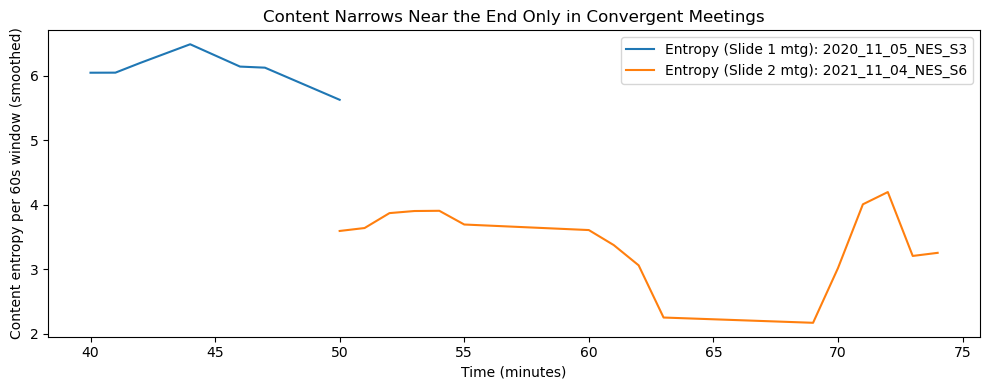


Slide 1 meeting: 2020_11_05_NES_S3
Entropy last-third mean: 6.060008857677105
Entropy last-third median: 6.052809129607118

Slide 2 meeting: 2021_11_04_NES_S6
Entropy last-third mean: 3.4155037835491413
Entropy last-third median: 3.6385696393167644


In [42]:
from pathlib import Path
import json, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# SLIDE 3: "Entropy shows narrowing (or not) near the end"
# ============================================================

# ----------------------------
# CONFIG (match Slide 1/2)
# ----------------------------
BIN_SEC = 60
SMOOTH_WINDOW_BINS = 3
PLOT_LAST_THIRD_ONLY = True
EXCLUDE_STRUCTURAL_FROM_ENTROPY = True  # recommended

# Slide 1 meeting (decision != convergence example)
SESSION_FP1 = Path(
    "/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/"
    "gemini_data_analysis/data/2020NES/session_data/2020_11_05_NES_S3.json"
)

# Slide 2 meeting (convergence example)
SESSION_FP2 = Path(
    "/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/"
    "gemini_data_analysis/data/2021NES/session_data/2021_11_04_NES_S6.json"
)

# ----------------------------
# Helpers (same style as yours)
# ----------------------------
def time_str_to_sec(s: str) -> float:
    if not isinstance(s, str) or ":" not in s:
        return np.nan
    parts = s.split(":")
    try:
        parts = [int(p) for p in parts]
    except ValueError:
        return np.nan
    if len(parts) == 2:
        mm, ss = parts
        return mm * 60 + ss
    if len(parts) == 3:
        hh, mm, ss = parts
        return hh * 3600 + mm * 60 + ss
    return np.nan

def extract_utterances_scialog(session_json: dict) -> pd.DataFrame:
    rows = []
    for i, u in enumerate(session_json.get("all_data", [])):
        if not isinstance(u, dict):
            continue

        start_time = u.get("start_time")
        end_time   = u.get("end_time")
        start_sec  = time_str_to_sec(start_time)
        end_sec    = time_str_to_sec(end_time)

        text = (u.get("transcript", "") or "").strip()
        ann = u.get("annotations", {})
        codes = list(ann.keys()) if isinstance(ann, dict) else []

        rows.append({
            "idx": i,
            "start_time": start_time,
            "end_time": end_time,
            "start_sec": start_sec,
            "end_sec": end_sec,
            "text": text,
            "codes": codes,
        })

    df = pd.DataFrame(rows)
    df["start_sec"] = pd.to_numeric(df["start_sec"], errors="coerce")
    df["end_sec"]   = pd.to_numeric(df["end_sec"], errors="coerce")
    df = df.dropna(subset=["start_sec"]).sort_values("start_sec").reset_index(drop=True)

    # Fill missing end times using next start time
    df["next_start_sec"] = df["start_sec"].shift(-1)
    df["end_sec"] = df["end_sec"].fillna(df["next_start_sec"])
    df["end_sec"] = df["end_sec"].fillna(df["start_sec"])
    df["dur_sec"] = (df["end_sec"] - df["start_sec"]).clip(lower=0)

    df["t_sec"] = df["start_sec"]
    df["t_min"] = df["t_sec"] / 60.0

    return df.drop(columns=["next_start_sec"])

def has_any_code(codes, target_set):
    return any(c in target_set for c in codes)

# ----------------------------
# Signals (keep consistent)
# ----------------------------
COMMITMENT_CODES = {"Coordination and Decision Practices"}

STRUCTURAL_WRAP_PAT = re.compile(
    r"\b("
    r"wrap up|time|times up|run out of time|hard stop|"
    r"next meeting|next steps|follow up|send|email|"
    r"slides?|deck|presentation|present|report out|report-out|"
    r"agenda|minutes|summar(y|ize)|"
    r"let's move on|we should stop|have to go|"
    r"screen sharing|screenshare|slide number"
    r")\b",
    flags=re.IGNORECASE
)

# ----------------------------
# Entropy utilities
# ----------------------------
# tiny stopword set so you don't need external libraries
STOPWORDS = {
    "the","a","an","and","or","but","if","so","to","of","in","on","for","with",
    "we","i","you","they","he","she","it","this","that","these","those",
    "is","are","was","were","be","been","being","do","does","did",
    "have","has","had","will","would","can","could","should","may","might",
    "at","as","by","from","about","into","over","under","than","then",
    "yeah","okay","ok","um","uh","like"
}

TOKEN_PAT = re.compile(r"[a-zA-Z']+")

def tokenize(text: str):
    toks = [t.lower() for t in TOKEN_PAT.findall(text or "")]
    toks = [t for t in toks if t not in STOPWORDS and len(t) > 2]
    return toks

def shannon_entropy(tokens):
    if not tokens:
        return np.nan
    counts = {}
    for t in tokens:
        counts[t] = counts.get(t, 0) + 1
    total = sum(counts.values())
    probs = [c / total for c in counts.values()]
    # log2 entropy
    return -sum(p * math.log2(p) for p in probs if p > 0)

# ----------------------------
# Build per-meeting bin summary with entropy + coordination
# ----------------------------
def build_entropy_bins(session_fp: Path):
    with open(session_fp, "r") as f:
        session = json.load(f)

    df = extract_utterances_scialog(session)

    df["is_commitment_code"] = df["codes"].apply(lambda cs: has_any_code(cs, COMMITMENT_CODES))
    df["is_structural_wrap"] = df["text"].apply(lambda t: bool(STRUCTURAL_WRAP_PAT.search(t)))

    # last third cutoff
    meeting_start = float(df["start_sec"].min())
    meeting_end   = float(df["end_sec"].max())
    meeting_len   = max(1.0, meeting_end - meeting_start)
    t2 = meeting_start + 2.0 * meeting_len / 3.0

    plot_df = df[df["t_sec"] >= t2].copy() if PLOT_LAST_THIRD_ONLY else df.copy()

    # binning
    plot_df["t_bin"] = (plot_df["t_sec"] // BIN_SEC).astype(int) * BIN_SEC

    # minutes of coordination/decision per bin (same metric as your slide lines)
    bin_cd = (
        plot_df.groupby("t_bin")
        .agg(
            cd_time_sec=("dur_sec", lambda s: float(s[plot_df.loc[s.index, "is_commitment_code"]].sum()))
        )
        .reset_index()
    )
    bin_cd["t_min"] = bin_cd["t_bin"] / 60.0
    bin_cd["cd_min"] = bin_cd["cd_time_sec"] / 60.0

    # entropy per bin (optionally exclude structural utterances)
    ent_rows = []
    for t_bin, g in plot_df.groupby("t_bin"):
        g2 = g[~g["is_structural_wrap"]].copy() if EXCLUDE_STRUCTURAL_FROM_ENTROPY else g
        toks = []
        for txt in g2["text"].tolist():
            toks.extend(tokenize(txt))
        ent_rows.append({"t_bin": t_bin, "entropy": shannon_entropy(toks)})

    bin_ent = pd.DataFrame(ent_rows)
    out = bin_cd.merge(bin_ent, on="t_bin", how="left").sort_values("t_bin")

    # smoothing (match your slides)
    out["cd_smooth"] = out["cd_min"].rolling(SMOOTH_WINDOW_BINS, 1).mean()
    out["entropy_smooth"] = out["entropy"].rolling(SMOOTH_WINDOW_BINS, 1).mean()

    return out, df, plot_df

# ----------------------------
# Run both meetings
# ----------------------------
bins1, df1, plot1 = build_entropy_bins(SESSION_FP1)
bins2, df2, plot2 = build_entropy_bins(SESSION_FP2)

# ----------------------------
# SLIDE 3 PLOT: Entropy (narrowing) in last third, compare two meetings
# ----------------------------
plt.figure(figsize=(10,4))
plt.plot(bins1["t_min"], bins1["entropy_smooth"], label=f"Entropy (Slide 1 mtg): {SESSION_FP1.stem}")
plt.plot(bins2["t_min"], bins2["entropy_smooth"], label=f"Entropy (Slide 2 mtg): {SESSION_FP2.stem}")
plt.xlabel("Time (minutes)")
suffix = " (last third)" if PLOT_LAST_THIRD_ONLY else ""
excl = " (excluding structural closure)" if EXCLUDE_STRUCTURAL_FROM_ENTROPY else ""
plt.ylabel(f"Content entropy per {BIN_SEC}s window (smoothed)")
plt.title(f"Content Narrows Near the End Only in Convergent Meetings")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# Optional: tiny numeric summary (good for speaker notes)
# ----------------------------
def summarize_entropy(bins_df, label):
    valid = bins_df["entropy"].dropna()
    if len(valid) == 0:
        print(label, "No entropy computed (empty bins).")
        return
    print(f"\n{label}")
    print("Entropy last-third mean:", float(valid.mean()))
    print("Entropy last-third median:", float(valid.median()))

summarize_entropy(bins1, f"Slide 1 meeting: {SESSION_FP1.stem}")
summarize_entropy(bins2, f"Slide 2 meeting: {SESSION_FP2.stem}")

### Slide 10 - Part 4

Convergence Defined by Co-occurring Signals

Unit of Analysis: 60-second time bins of utterances within a meeting.

What’s Tracked: Annotation Codes (Coordination/Decision Practices) treated as categorical states.

Entropy Used: Shannon entropy over the distribution of active annotation codes within each 60-second bin.


### Slide 10 - Part 5

When Do We Call a Moment ‘Convergent’?

From the session examples:
Sustained Coordination/Decision Practices activity

Low entropy, indicating discussion concentrates on fewer ideas

Absence of structural closure


### Slide 10 - Part 6

Why Use Entropy as a Signal of Convergence?

From the previous slides, convergence has been articulated as a process of narrowing down the distribution of ideas under discussion. 
Entropy quantifies that narrowing.


### Slide 10 - Part 7

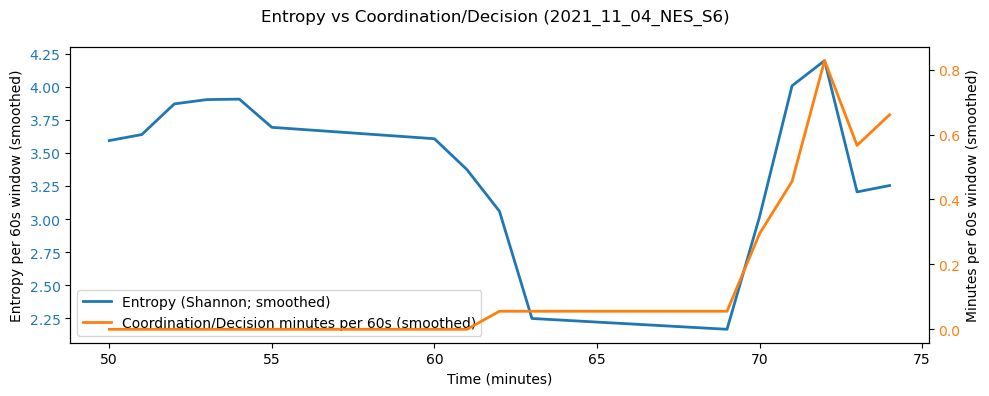


[2021_11_04_NES_S6] bins in window: 16
Entropy mean: 3.4155037835491413 | median: 3.6385696393167644
Coord/Decision minutes per 60s mean: 0.21979166666666666


In [46]:
# ============================================================
# SLIDE 7:
# Entropy vs Coordination/Decision (and optional structural wrap-up)
# Uses Slide 3 outputs: bins1/bins2 and plot1/plot2
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# CONFIG
# ----------------------------
WHICH = 2              # 1 -> Slide 1 meeting, 2 -> Slide 2 meeting
PLOT_STRUCTURAL = False # include structural wrap-up minutes as a third line (same axis as minutes)

# ----------------------------
# Sanity: require Slide 3 outputs
# ----------------------------
required = ["bins1", "bins2", "plot1", "plot2", "BIN_SEC", "SMOOTH_WINDOW_BINS", "SESSION_FP1", "SESSION_FP2"]
missing = [x for x in required if x not in globals()]
if missing:
    raise NameError(
        f"Missing variables from Slide 3 chunk: {missing}\n"
        "Run your Slide 3 code cell first so bins1/bins2/plot1/plot2 exist."
    )

# ----------------------------
# Pick meeting
# ----------------------------
if WHICH == 1:
    bins_entropy = bins1.copy()   # columns: t_bin, t_min, cd_min, cd_smooth, entropy, entropy_smooth
    plot_df = plot1.copy()        # utterance-level df in plotted window (last third if enabled)
    session_stem = SESSION_FP1.stem
elif WHICH == 2:
    bins_entropy = bins2.copy()
    plot_df = plot2.copy()
    session_stem = SESSION_FP2.stem
else:
    raise ValueError("WHICH must be 1 or 2.")

# Core bins
bins = bins_entropy[["t_bin", "t_min", "entropy", "entropy_smooth", "cd_min", "cd_smooth"]].copy()

# ----------------------------
# Structural minutes per bin (optional)
# ----------------------------
if PLOT_STRUCTURAL:
    if "is_structural_wrap" not in plot_df.columns:
        raise NameError(
            "plot_df is missing 'is_structural_wrap'. "
            "In Slide 3, build_entropy_bins() must create df['is_structural_wrap']."
        )

    structural_bins = (
        plot_df.groupby("t_bin")
        .agg(
            structural_time_sec=("dur_sec", lambda s: float(s[plot_df.loc[s.index, "is_structural_wrap"]].sum()))
        )
        .reset_index()
    )
    structural_bins["structural_min"] = structural_bins["structural_time_sec"] / 60.0
    structural_bins["structural_smooth"] = structural_bins["structural_min"].rolling(SMOOTH_WINDOW_BINS, 1).mean()

    bins = bins.merge(structural_bins[["t_bin", "structural_min", "structural_smooth"]],
                      on="t_bin", how="left")
else:
    bins["structural_smooth"] = np.nan

# ----------------------------
# PLOT: two y-axes (units stay honest)
# ----------------------------
fig, ax_entropy = plt.subplots(figsize=(10,4))

# Left axis: entropy (bits) — BLUE
ax_entropy.plot(
    bins["t_min"],
    bins["entropy_smooth"],
    color="tab:blue",
    linewidth=2,
    label="Entropy (Shannon; smoothed)"
)
ax_entropy.set_xlabel("Time (minutes)")
ax_entropy.set_ylabel(f"Entropy per {BIN_SEC}s window (smoothed)")
ax_entropy.tick_params(axis="y", labelcolor="tab:blue")

# Right axis: minutes per bin
ax_minutes = ax_entropy.twinx()

# Coordination/Decision — ORANGE
ax_minutes.plot(
    bins["t_min"],
    bins["cd_smooth"],
    color="tab:orange",
    linewidth=2,
    label=f"Coordination/Decision minutes per {BIN_SEC}s (smoothed)"
)

# Structural wrap-up — GRAY (optional)
if PLOT_STRUCTURAL:
    ax_minutes.plot(
        bins["t_min"],
        bins["structural_smooth"],
        color="tab:gray",
        linestyle="--",
        linewidth=2,
        label=f"Structural wrap-up minutes per {BIN_SEC}s (regex; smoothed)"
    )

ax_minutes.set_ylabel(f"Minutes per {BIN_SEC}s window (smoothed)")
ax_minutes.tick_params(axis="y", labelcolor="tab:orange")

# Title
fig.suptitle(f"Entropy vs Coordination/Decision ({session_stem})")

# Combined legend
lines1, labels1 = ax_entropy.get_legend_handles_labels()
lines2, labels2 = ax_minutes.get_legend_handles_labels()
ax_entropy.legend(lines1 + lines2, labels1 + labels2, loc="lower left")

plt.tight_layout()
plt.show()

# ----------------------------
# Quick numeric summary (speaker notes)
# ----------------------------
valid_e = bins["entropy"].dropna()
valid_cd = bins["cd_min"].dropna()

print(f"\n[{session_stem}] bins in window: {len(bins)}")
if len(valid_e) > 0:
    print("Entropy mean:", float(valid_e.mean()), "| median:", float(valid_e.median()))
if len(valid_cd) > 0:
    print(f"Coord/Decision minutes per {BIN_SEC}s mean:", float(valid_cd.mean()))

if PLOT_STRUCTURAL and "structural_min" in bins.columns:
    valid_s = bins["structural_min"].dropna()
    if len(valid_s) > 0:
        print(f"Structural wrap-up minutes per {BIN_SEC}s mean:", float(valid_s.mean()))

### Slide 10 - Part 8

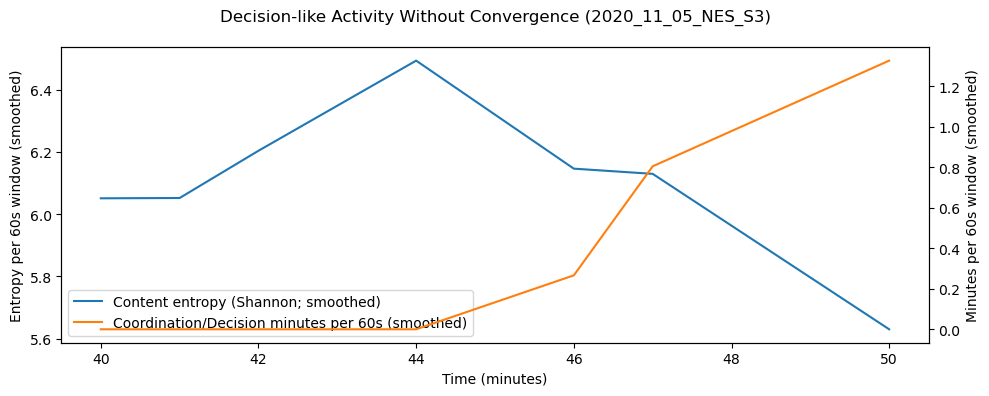


Transcript context window: 2020_11_05_NES_S3
Centered at ~50.00 min  (showing 47.00–53.00 min)

- (47:14–47:28) [Coord/Decision] Oh. Well so they they asked for just a few of the topics or points or ideas that we discussed that we all agreed were most most interesting to share.
- (47:28–48:51) [Coord/Decision] Okay. I think we'd like to pick a few for you to Okay, one second. Let me put it on this one here because I have a bigger screen. Yeah, so thank you for doing this. It's not I know it's very hard work. Oh no no no not at all. I'd rather listen and write it dow…
- (50:00–50:24) [Coord/Decision] try to narrow the focus for a few of the things that people think are most compelling to to share with the broader group. So does anybody have a topic or theme here that they'd they really feel was was is worth taking to everyone?
- (50:24–50:33) [Coord/Decision] I think that discussion on improving the quinone chemistries or alternatives to quinone chemistries, I think that was very produ

In [44]:
# ============================================================
# SLIDE 8:
# When Signals Disagree — Coordination without Convergence
# + EXTENDED transcript context extraction
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# CONFIG
# ----------------------------
bins = bins1.copy()
session_stem = SESSION_FP1.stem          # 2020_11_05_NES_S3
plot_df = plot1.copy()                  # utterance-level DF from Slide 3

# Transcript extraction controls
WINDOW_MINUTES_HALF_WIDTH = 3.0          # +/- minutes (EXTENDED)
MAX_UTTERANCES = 25                      # allow more context
ONLY_SHOW_COORDINATION_UTTS = False
SHOW_STRUCTURAL_TOO = True
MANUAL_CENTER_MIN = None                 # override if needed

# ----------------------------
# PLOT (same as before)
# ----------------------------
fig, ax_entropy = plt.subplots(figsize=(10,4))

ax_entropy.plot(
    bins["t_min"], bins["entropy_smooth"],
    color="tab:blue",
    label="Content entropy (Shannon; smoothed)"
)
ax_entropy.set_xlabel("Time (minutes)")
ax_entropy.set_ylabel(f"Entropy per {BIN_SEC}s window (smoothed)")

ax_minutes = ax_entropy.twinx()
ax_minutes.plot(
    bins["t_min"], bins["cd_smooth"],
    color="tab:orange",
    label=f"Coordination/Decision minutes per {BIN_SEC}s (smoothed)"
)
ax_minutes.set_ylabel(f"Minutes per {BIN_SEC}s window (smoothed)")

fig.suptitle(f"Decision-like Activity Without Convergence ({session_stem})")

lines1, labels1 = ax_entropy.get_legend_handles_labels()
lines2, labels2 = ax_minutes.get_legend_handles_labels()
ax_entropy.legend(lines1 + lines2, labels1 + labels2, loc="lower left")

plt.tight_layout()
plt.show()

# ----------------------------
# Pick center moment
# ----------------------------
if MANUAL_CENTER_MIN is None:
    idx_peak = bins["cd_smooth"].fillna(-np.inf).idxmax()
    center_min = float(bins.loc[idx_peak, "t_min"])
else:
    center_min = float(MANUAL_CENTER_MIN)

start_min = center_min - WINDOW_MINUTES_HALF_WIDTH
end_min   = center_min + WINDOW_MINUTES_HALF_WIDTH

print("\n==============================")
print(f"Transcript context window: {session_stem}")
print(f"Centered at ~{center_min:.2f} min  (showing {start_min:.2f}–{end_min:.2f} min)")
print("==============================\n")

# ----------------------------
# Prepare DF safely
# ----------------------------
if "t_min" not in plot_df.columns:
    plot_df["t_min"] = plot_df["t_sec"] / 60.0

plot_df["is_commitment_code"] = plot_df.get("is_commitment_code", False)
plot_df["is_structural_wrap"] = plot_df.get("is_structural_wrap", False)

# ----------------------------
# Filter window
# ----------------------------
ctx = plot_df[
    (plot_df["t_min"] >= start_min) &
    (plot_df["t_min"] <= end_min)
].copy()

if ONLY_SHOW_COORDINATION_UTTS:
    ctx = ctx[ctx["is_commitment_code"]]

if not SHOW_STRUCTURAL_TOO:
    ctx = ctx[~ctx["is_structural_wrap"]]

ctx = ctx.sort_values("t_sec").head(MAX_UTTERANCES)

# ----------------------------
# Pretty print transcript
# ----------------------------
def _clean(s: str) -> str:
    return " ".join(str(s).split())

if len(ctx) == 0:
    print("No utterances found in this window.")
else:
    for _, r in ctx.iterrows():
        tags = []
        if r["is_commitment_code"]:
            tags.append("Coord/Decision")
        if r["is_structural_wrap"]:
            tags.append("Structural")

        tag = f"[{', '.join(tags)}]" if tags else ""

        if isinstance(r.get("start_time"), str) and isinstance(r.get("end_time"), str):
            time_str = f"{r['start_time']}–{r['end_time']}"
        else:
            time_str = f"{r['t_min']:.2f} min"

        text = _clean(r.get("text", ""))
        if len(text) > 260:
            text = text[:260].rstrip() + "…"

        print(f"- ({time_str}) {tag} {text}")

In [45]:
from pathlib import Path
import json
import pandas as pd
import numpy as np

# Path to the session
SESSION_FP = Path(
    "/Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/"
    "gemini_data_analysis/data/2020NES/session_data/2020_11_05_NES_S3.json"
)

def time_str_to_sec(s: str) -> float:
    if not isinstance(s, str) or ":" not in s:
        return np.nan
    parts = [int(p) for p in s.split(":")]
    if len(parts) == 2:
        mm, ss = parts
        return mm * 60 + ss
    if len(parts) == 3:
        hh, mm, ss = parts
        return hh * 3600 + mm * 60 + ss
    return np.nan

# Load session
with open(SESSION_FP, "r") as f:
    session = json.load(f)

# Extract start times
times_sec = [
    time_str_to_sec(u.get("start_time"))
    for u in session.get("all_data", [])
    if isinstance(u, dict)
]

times_sec = pd.Series(times_sec).dropna()

# Compute duration
start_sec = times_sec.min()
end_sec   = times_sec.max()
duration_min = (end_sec - start_sec) / 60

print(f"Session duration: {duration_min:.2f} minutes")

Session duration: 50.98 minutes


# Organizing the repo

Using file: /Users/maxchalekson/Northwestern University/Summer-2025/NICO/NICO Research/linkography_ai/data/2021NES/session_data/2021_11_04_NES_S6.json
Exists: True


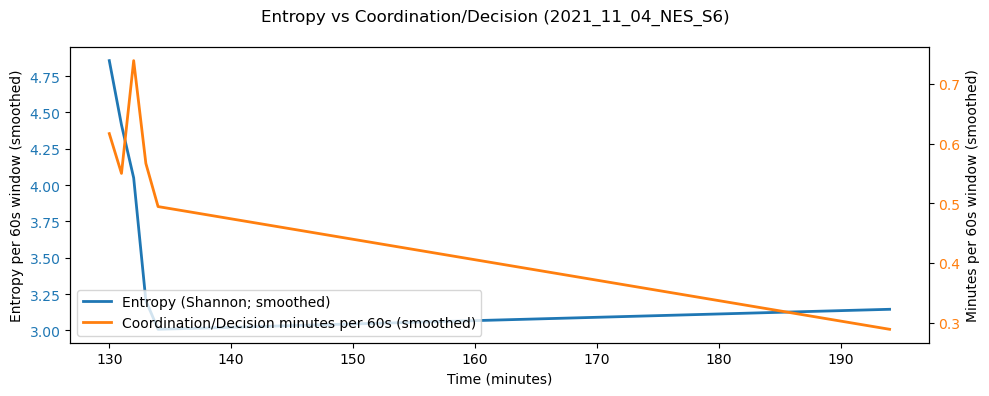

In [8]:
from pathlib import Path
from linkography_ai.slides import compute_entropy_vs_cd, plot_entropy_vs_cd

# Relative to repo root
SESSION_FP = Path("data/2021NES/session_data/2021_11_04_NES_S6.json")

print("Using file:", SESSION_FP.resolve())
print("Exists:", SESSION_FP.exists())

bins, plot_df = compute_entropy_vs_cd(
    SESSION_FP,
    bin_sec=60,
    smooth_window=3,
    last_third_only=True,
    exclude_structural_from_entropy=True,
)

fig, ax1, ax2 = plot_entropy_vs_cd(
    bins,
    session_stem=SESSION_FP.stem,
    bin_sec=60,
    plot_structural=False,
)

In [9]:
from pathlib import Path
from linkography_ai.slides import compute_entropy_vs_cd

SESSION_FP = Path("data/2021NES/session_data/2021_11_04_NES_S6.json")

bins, plot_df = compute_entropy_vs_cd(
    SESSION_FP,
    bin_sec=60,
    smooth_window=3,
    last_third_only=True,
    exclude_structural_from_entropy=True,
)

print("plot_df t_sec min/max:", plot_df["t_sec"].min(), plot_df["t_sec"].max())
print("plot_df duration (min):", (plot_df["t_sec"].max() - plot_df["t_sec"].min())/60)
print("bins t_min min/max:", bins["t_min"].min(), bins["t_min"].max())
print("bins span (min):", bins["t_min"].max() - bins["t_min"].min())

plot_df t_sec min/max: 7816.0 11681.0
plot_df duration (min): 64.41666666666667
bins t_min min/max: 130.0 194.0
bins span (min): 64.0
